# A Change Prediction Method

From (Clarkson et al., 2004)

Clarkson, P.J., Simons, C. and Eckert, C. (2004), “Predicting Change Propagation in Complex Design”, Journal of Mechanical Design, Vol. 126 No. 5, p. 788.

## Imports

In [1]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import networkx as nx
import random
import seaborn as sns
import numpy as np
import uuid

## Auxiliary functions

In [2]:
def random_DSM(size: int) -> list:
    """Create a random DSM of order 'size'"""
    DSM = []
    for i in range(size):
        row = []
        for j in range(size):
            if j == i:
                row.append(0)
            else:
                row.append(random.randint(0, 1))
        DSM.append(row)
    return DSM

In [3]:
def ppm(aMatrix: list):
    """Pretty Print aMatrix"""
    print('\n'.join(['\t'.join([str("{:.3f}".format(cell)) for cell in row]) for row in aMatrix]))

In [4]:
def random_prob_matrix(aDSM: list):
    """Create a random probability matrix for aDSM"""
    probability_matrix = copy.deepcopy(aDSM)
    for i, row in enumerate(probability_matrix):
        for j, element in enumerate(row):
            if element == 1:
                P[i][j] = random.random()
    return probability_matrix


In [5]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
        the root will be found and used
    - if the tree is directed and this is given, then 
        the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
        then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [6]:
def plot_graph(aMatrix: list):
    """Plot a graph described by a DSM matrix A"""
    # Transform to a Numpy matrix for generating networkx graph
    aNumpyMatrix = np.matrix(aMatrix)
    g = nx.from_numpy_matrix(aNumpyMatrix, create_using=nx.DiGraph)

    # layout
    #pos = nx.spring_layout(G, iterations=50)
    pos = nx.spring_layout(g)
    labels = {}
    for i in range(Anp[0].size):
        labels[i] = str(i)
    # rendering
    plt.figure(figsize=(10,10))
    nx.draw_networkx_nodes(g, pos)
    nx.draw_networkx_edges(g, pos, node_size=1000, arrows=True)
    nx.draw_networkx_labels(g, pos, labels)
    plt.axis('off')

In [7]:
def plot_heatmap(aMatrix: list):
    """Plot aMatrix A as a heatmap"""
    color_palette = sns.color_palette("Blues", as_cmap=True)
    ax = sns.heatmap(aMatrix, linewidth=0.5, cmap=color_palette)
    plt.yticks(rotation=0)
    ax.xaxis.tick_top() # x axis on top
    ax.xaxis.set_label_position('top')
    ax.tick_params(length=0)
    # set aspect of all axis
    ax.set_aspect('equal','box')
    plt.show()

## Definitions

$a$: destination of change

$b$: source of change

$u$: pen-ultimate sub-system i the chain from **a** to **b**

$\sigma_{u,a}$: Likelihood of change reaching sub-system **u** from **a**

$l_{b,u}$: Direct likelihood of change propagation from  **u** to **b**

Risk of change propagating from **u** to **b**:

$\rho_{b,u} = \sigma_{u,a} l_{b,u} i_{b,u}$

Combined risk of change propagating from **b** to **a**:

$R_{b,a} = 1- \prod{(1 - \rho_{b,u})}$

## 1. Initial Analysis

### 1.1 Create Product Model

```
    a. power supply

    b. motor

    c. heating unit

    d. fan

    e. control system

    f. casing
```

In [8]:
product_components =   ['power supply',
                        'motor',
                        'heating unit',
                        'fan',
                        'control system',
                        'casing']

### 1.2 Complete Dependency Matrices
Within the DSM the column headings show instigating sub-systems and the row headings the affected sub-systems, whose designs change as a result of change to the instigating sub-systems.

In [13]:
# Design structure Matrix (DSM)
DSM =  [[0,1,1,0,0,0],
        [1,0,0,1,1,1],
        [1,0,0,1,1,1],
        [1,1,1,0,0,1],
        [0,0,1,1,0,1],
        [1,1,1,1,1,0]]
#ppm(DSM)

In [10]:
# Direct likelihood matrix (l)
direct_likelihood_matrix = [[0.0,0.3,0.3,0.0,0.0,0.0],
                            [0.9,0.0,0.0,0.6,0.3,0.6],
                            [0.9,0.0,0.0,0.6,0.3,0.6],
                            [0.3,0.6,0.9,0.0,0.0,0.9],
                            [0.0,0.0,0.3,0.6,0.0,0.3],
                            [0.3,0.9,0.6,0.9,0.6,0.0]]
#ppm(direct_likelihood_matrix)

In [11]:
# Direct impact matrix (i)
direct_impact_matrix = [[0.0,0.9,0.9,0.0,0.0,0.0],
                        [0.9,0.0,0.0,0.6,0.3,0.3],
                        [0.6,0.0,0.0,0.3,0.3,0.3],
                        [0.3,0.3,0.6,0.0,0.0,0.3],
                        [0.0,0.0,0.3,0.3,0.0,0.3],
                        [0.3,0.6,0.6,0.9,0.6,0.0]]
#ppm(direct_impact_matrix)

In [12]:
# Direct risk matrix (r)
direct_risk_matrix = (np.array(direct_likelihood_matrix)*np.array(direct_impact_matrix)).tolist()
ppm(direct_risk_matrix)

0.000	0.270	0.270	0.000	0.000	0.000
0.810	0.000	0.000	0.360	0.090	0.180
0.540	0.000	0.000	0.180	0.090	0.180
0.090	0.180	0.540	0.000	0.000	0.270
0.000	0.000	0.090	0.180	0.000	0.090
0.090	0.540	0.360	0.810	0.360	0.000


### 1.3 Compute Predictive Matrices

Source of change (initiating or instigating component): $a$

Target/Destination: $b$



The combined likelihood algorithm views propagation trees as logic trees. Vertical lines are mathematically represented by $\cup$, while horizontal lines are represented by $\cap$. For each tree, the And/Or summation begins at the bottom, farthest from the instigating subsystem. Through a combination of And and Or evaluations, a single combined likelihood value can be computed at the top of the tree. Since the events are not mutually exclusive the summations take the form:

*And* function as a product of probabilities:

$l_{b,u} \cup l_{b,v} = l_{b,u} \times l_{b,v}$

*Or* function as a sum of probabilities minus the product term (the inverse of the product of inverse probabilities):

$l_{b,u} \cap l_{b,v} = l_{b,u} + l_{b,v} - (l_{b,u} \times l_{b,v}) = 1 - ((1 - l_{b,u}) \times (1 - l_{b,v}))$

In [14]:
def likelihood(direct_likelihood_matrix: list,target: int,source: int):
    return direct_likelihood_matrix[source][target]

def and_function(direct_likelihood_matrix:list,b: int,u: int,v: int):
    return likelihood(direct_likelihood_matrix,b,u) * likelihood(direct_likelihood_matrix,b,v)

def or_function(direct_likelihood_matrix:list,b: int,u: int,v: int):
    return 1 - ((1 - likelihood(direct_likelihood_matrix,b,u)) * (1- likelihood(direct_likelihood_matrix,b,v)))

In [13]:
def propagation_tree(graph,target,source):

    propagation_tree = nx.DiGraph()

    for path in list(nx.all_simple_paths(graph, source, target)):
        new_path = []
        for level, node in enumerate(path, 1):
            node_id = ""
            for i in range(level):
                if i == 0:
                    node_id = str(path[i])
                else:
                    node_id = node_id + "-" + str(path[i])
            node_name = node
            node_level = level
            new_path.append(node_id)
            propagation_tree.add_node(node_id, name=node_name, level=node_level)
        nx.add_path(propagation_tree, new_path)
    
    return propagation_tree

In [14]:
def plot_propagation_tree(propagation_tree):
        labels = nx.get_node_attributes(propagation_tree, 'name') 
        pos = hierarchy_pos(propagation_tree)
        plt.figure(figsize=(40,10))
        options = {"with_labels": True, 
                "node_shape": "s", 
                "arrows": False,
                "node_color": "white", 
                "edgecolors": "black", 
                "node_size": 1500}
        nx.draw_networkx(propagation_tree, 
                        pos=pos, 
                        labels=labels, 
                        **options)

In [15]:
g = nx.from_numpy_matrix(np.transpose(np.matrix(DSM)), create_using=nx.DiGraph)

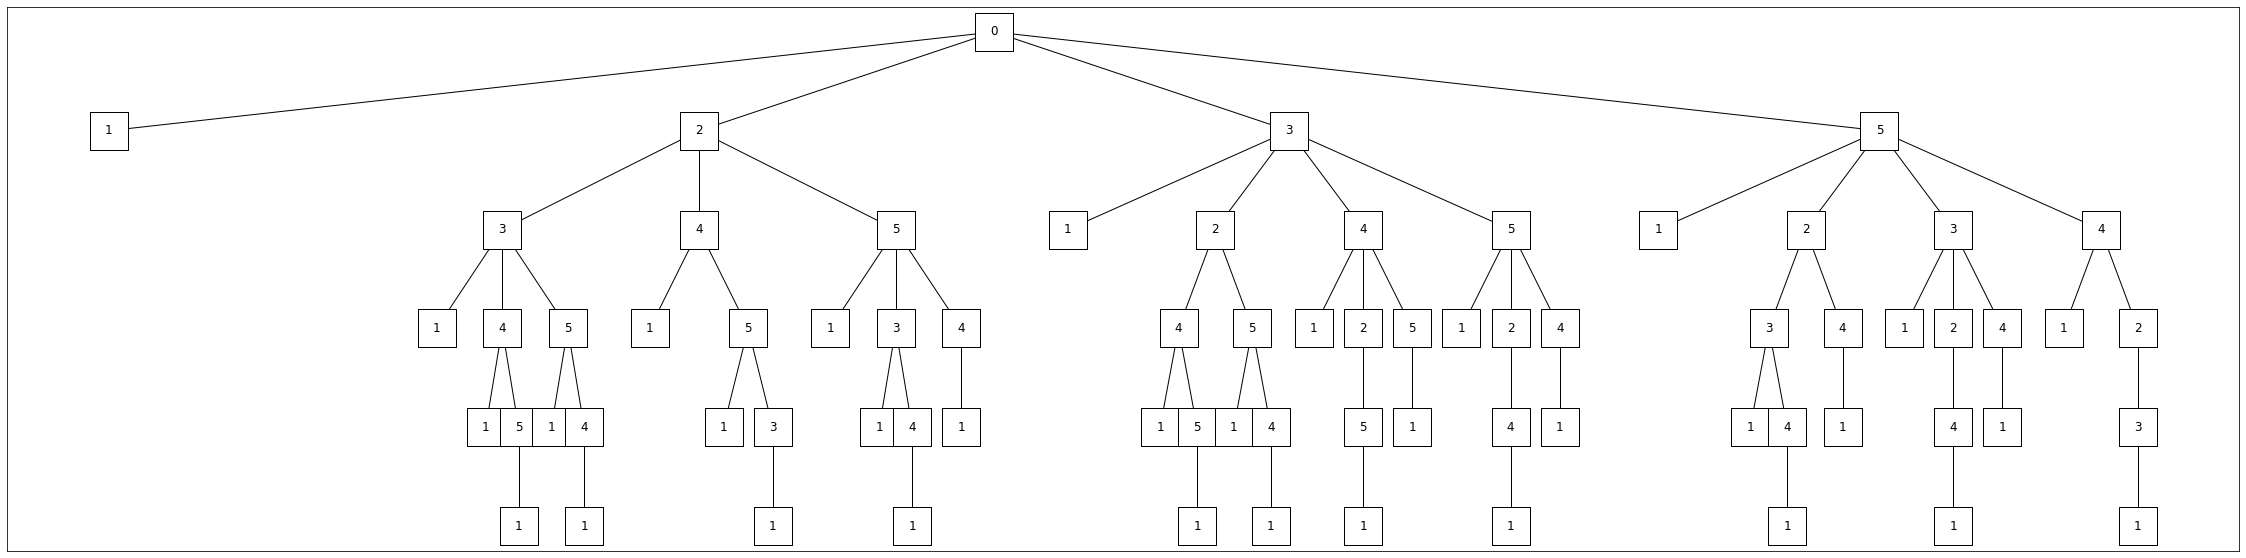

In [33]:
source = 0
target = 1

tree = propagation_tree(g,target,source)
plot_propagation_tree(tree)

In [39]:
def get_siblings(aGraph, aNode):
    """
    Get siblings of aNode in aGraph.
    :param: aNode: {str} 
    :param: aGraph: {networkx.DiGraph}
    :return: {list}
    """
    siblings = list(aGraph.successors(list(aGraph.predecessors(aNode))[0]))

    return siblings


In [45]:
siblings = get_siblings(tree,"0-1")

In [53]:
for sibling in siblings:
    print(sibling)
    print(tree.nodes[sibling])
    print("has parent: ")
    print(list(tree.predecessors(sibling)))

0-1
{'name': 1, 'level': 2}
has parent: 
['0']
0-2
{'name': 2, 'level': 2}
has parent: 
['0']
0-3
{'name': 3, 'level': 2}
has parent: 
['0']
0-5
{'name': 5, 'level': 2}
has parent: 
['0']


<ipython-input-14-7234b081c177>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(40,10))


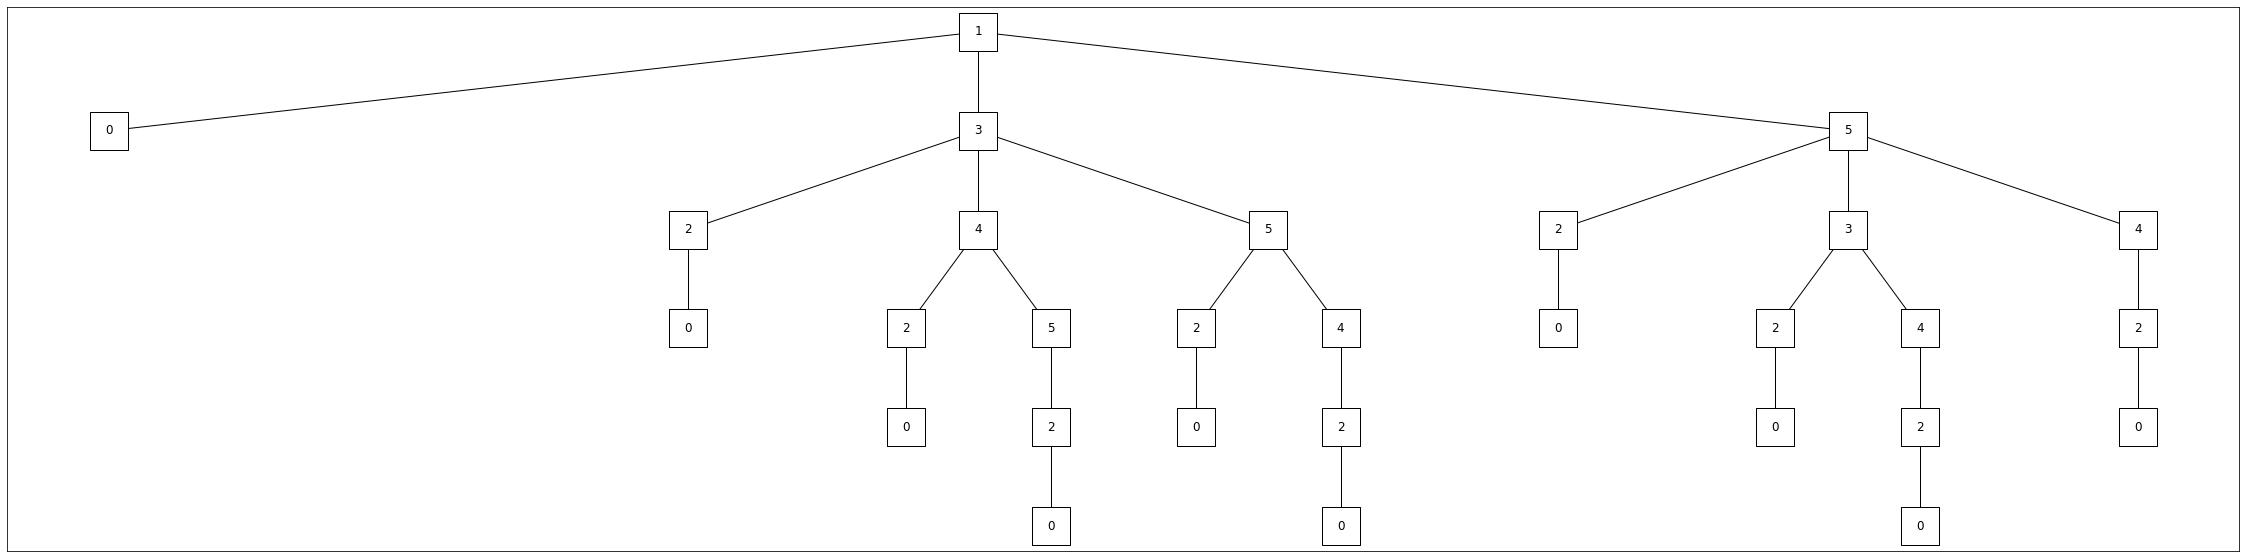

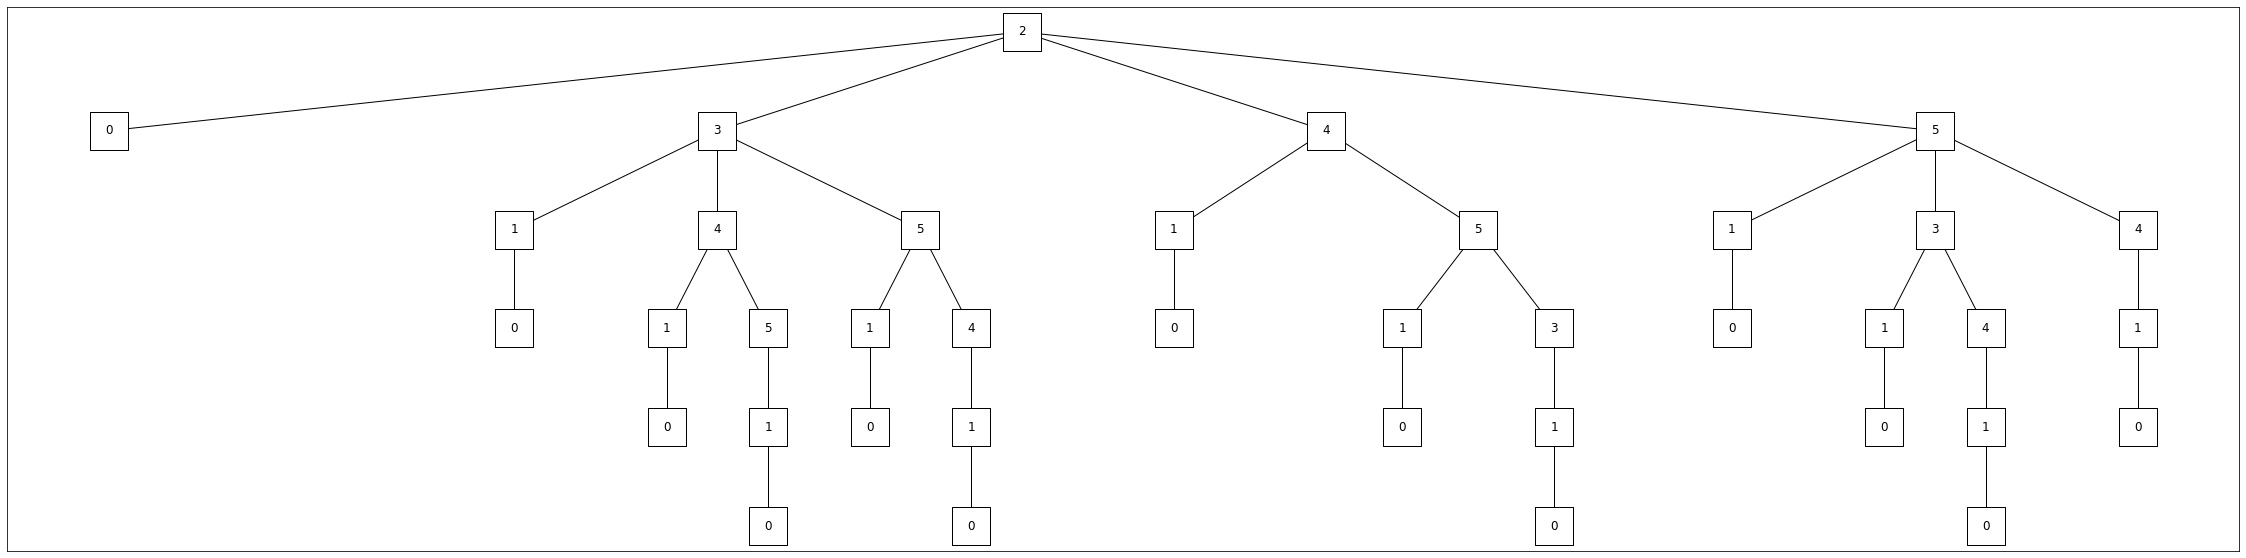

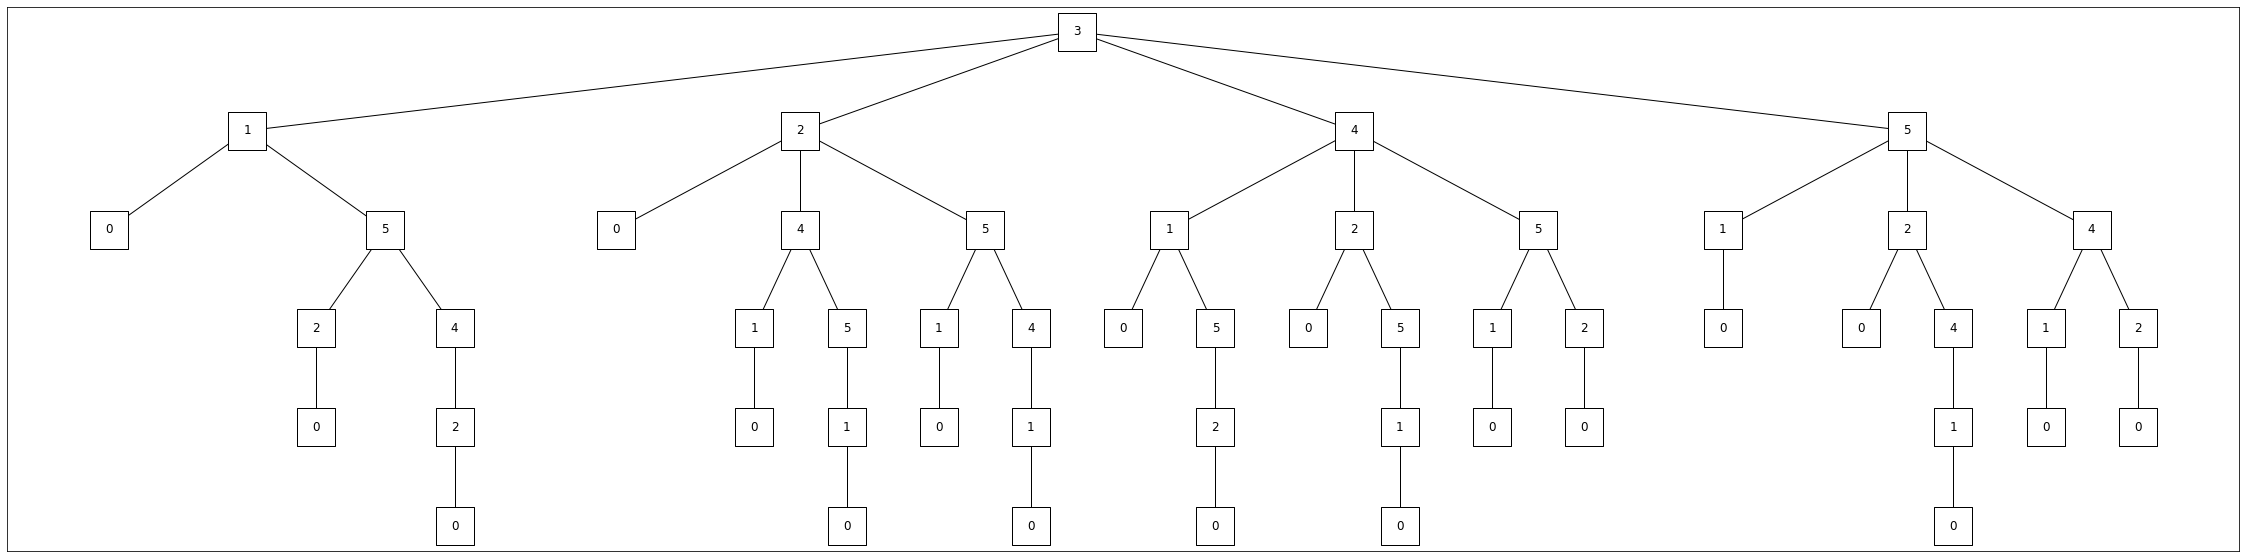

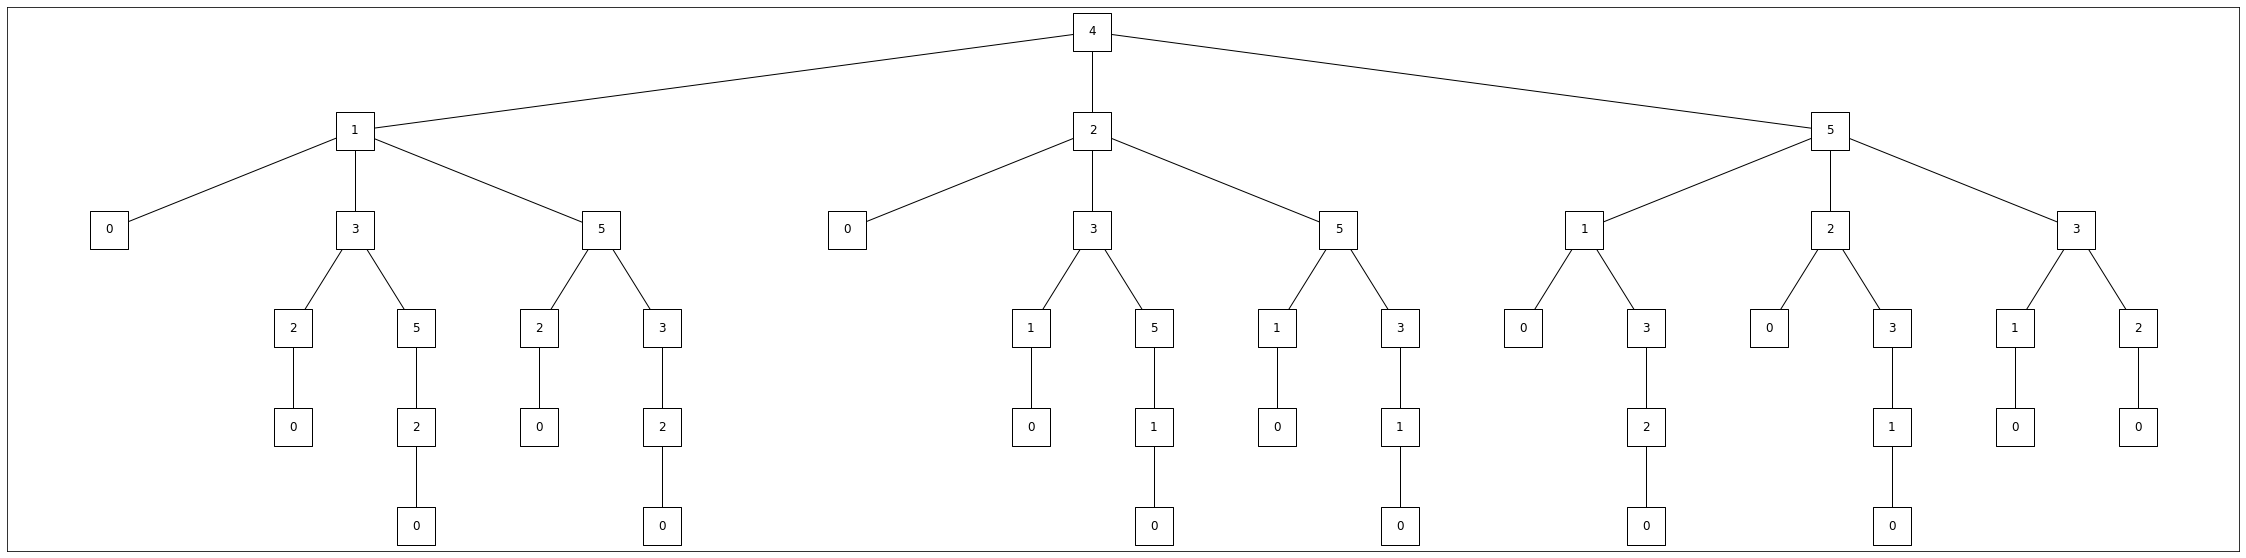

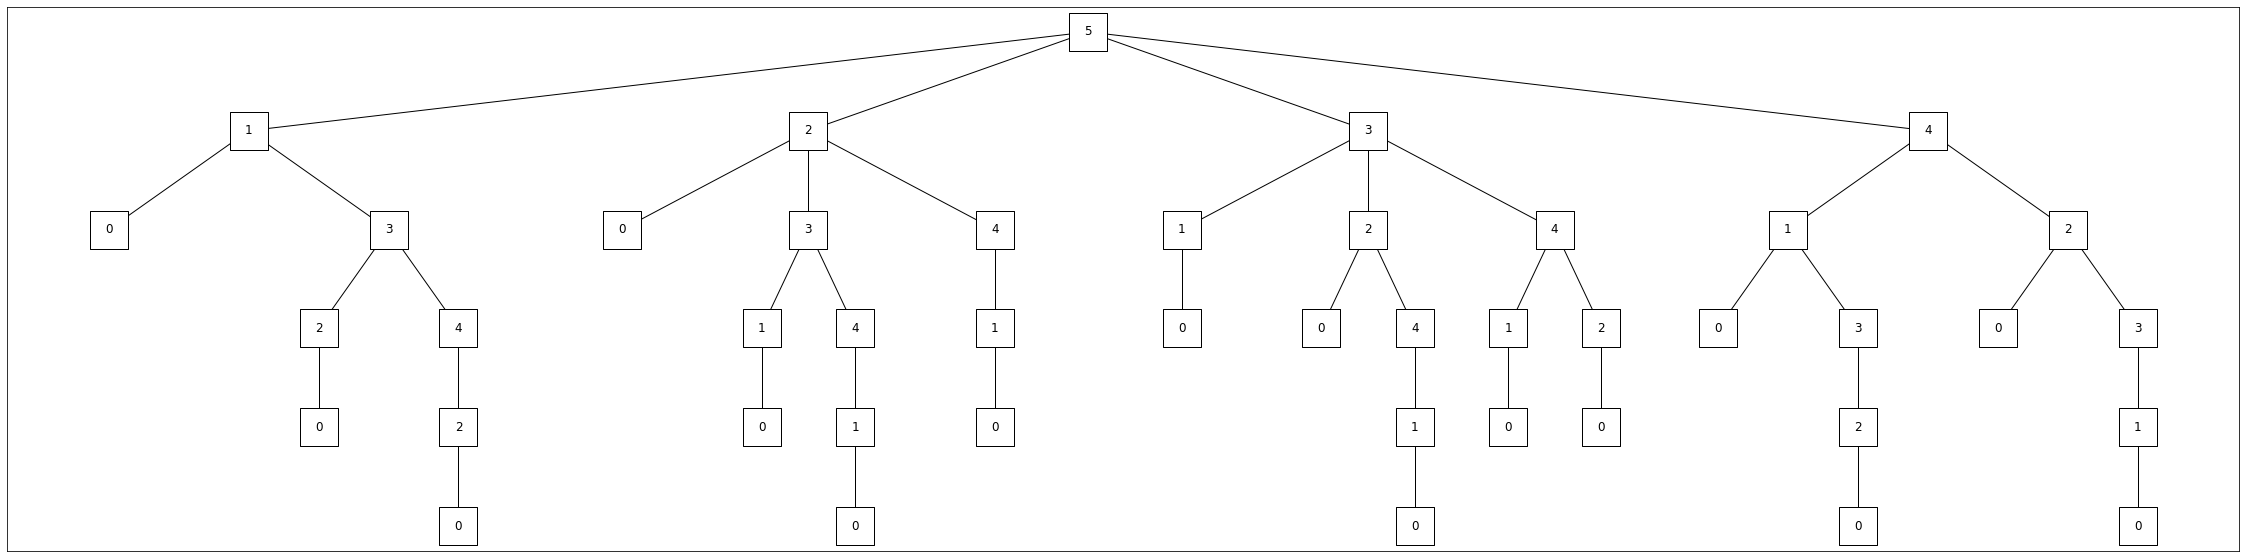

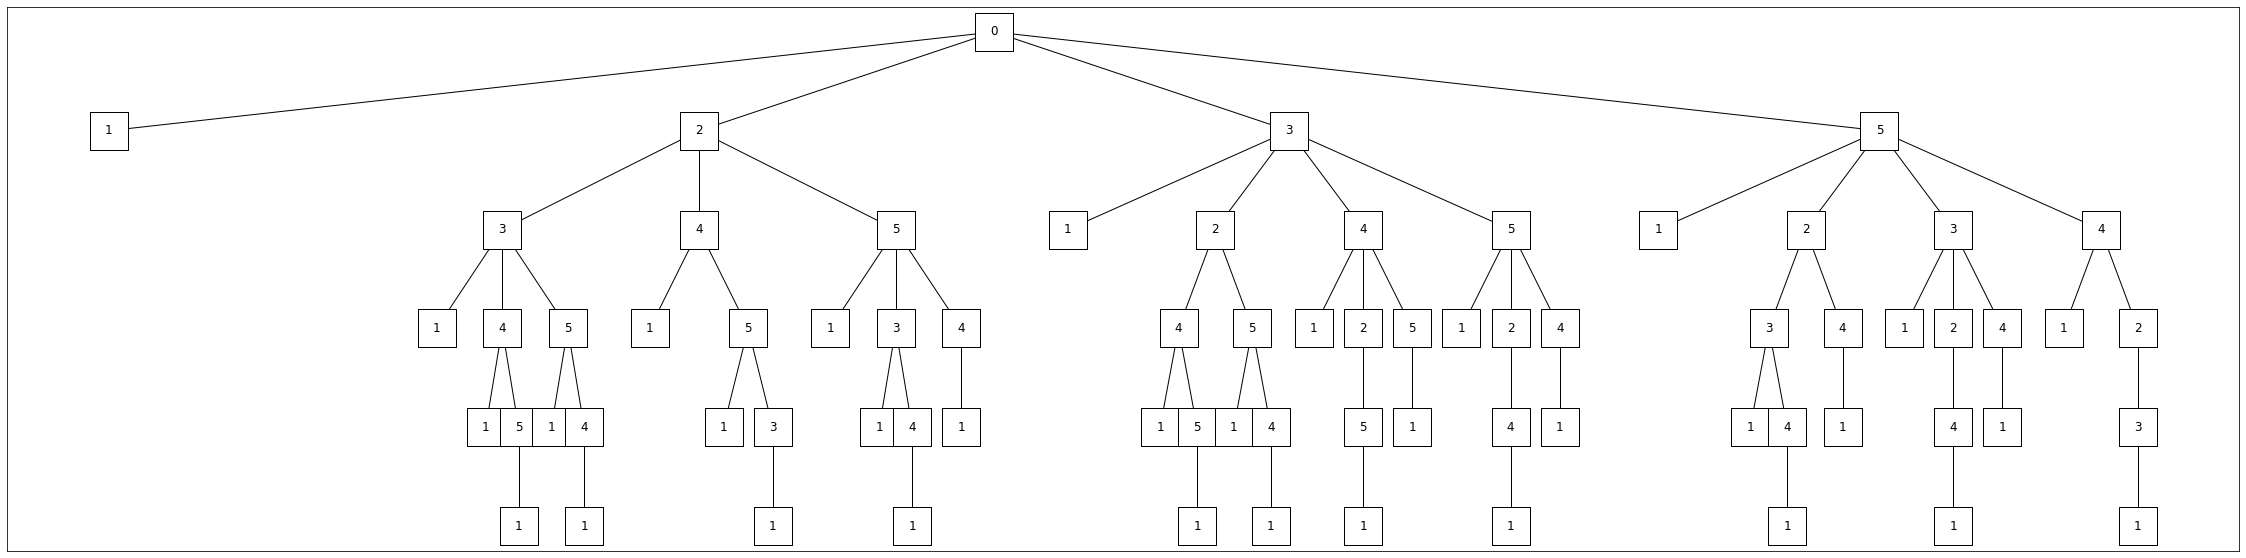

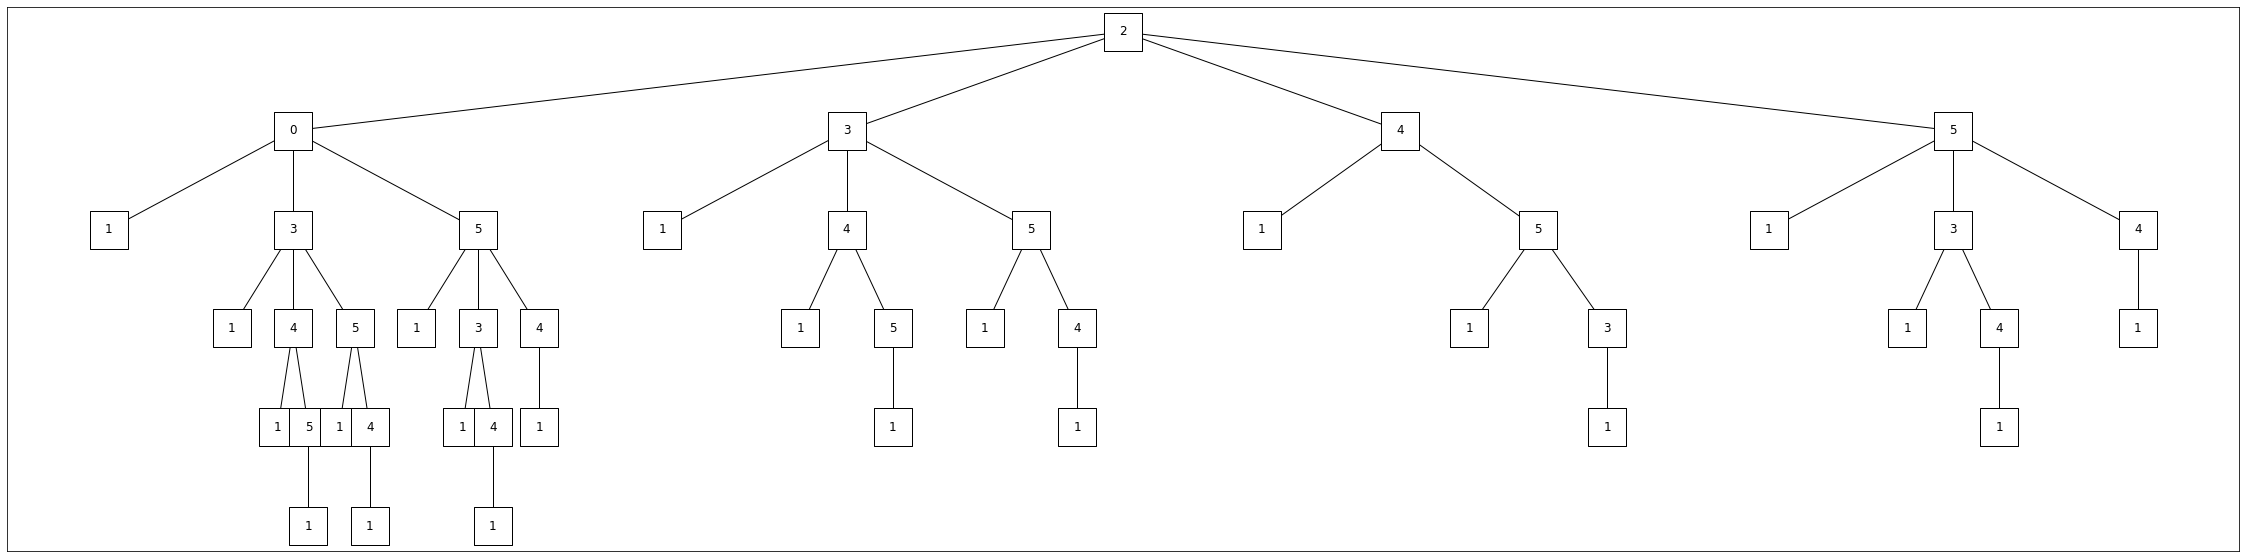

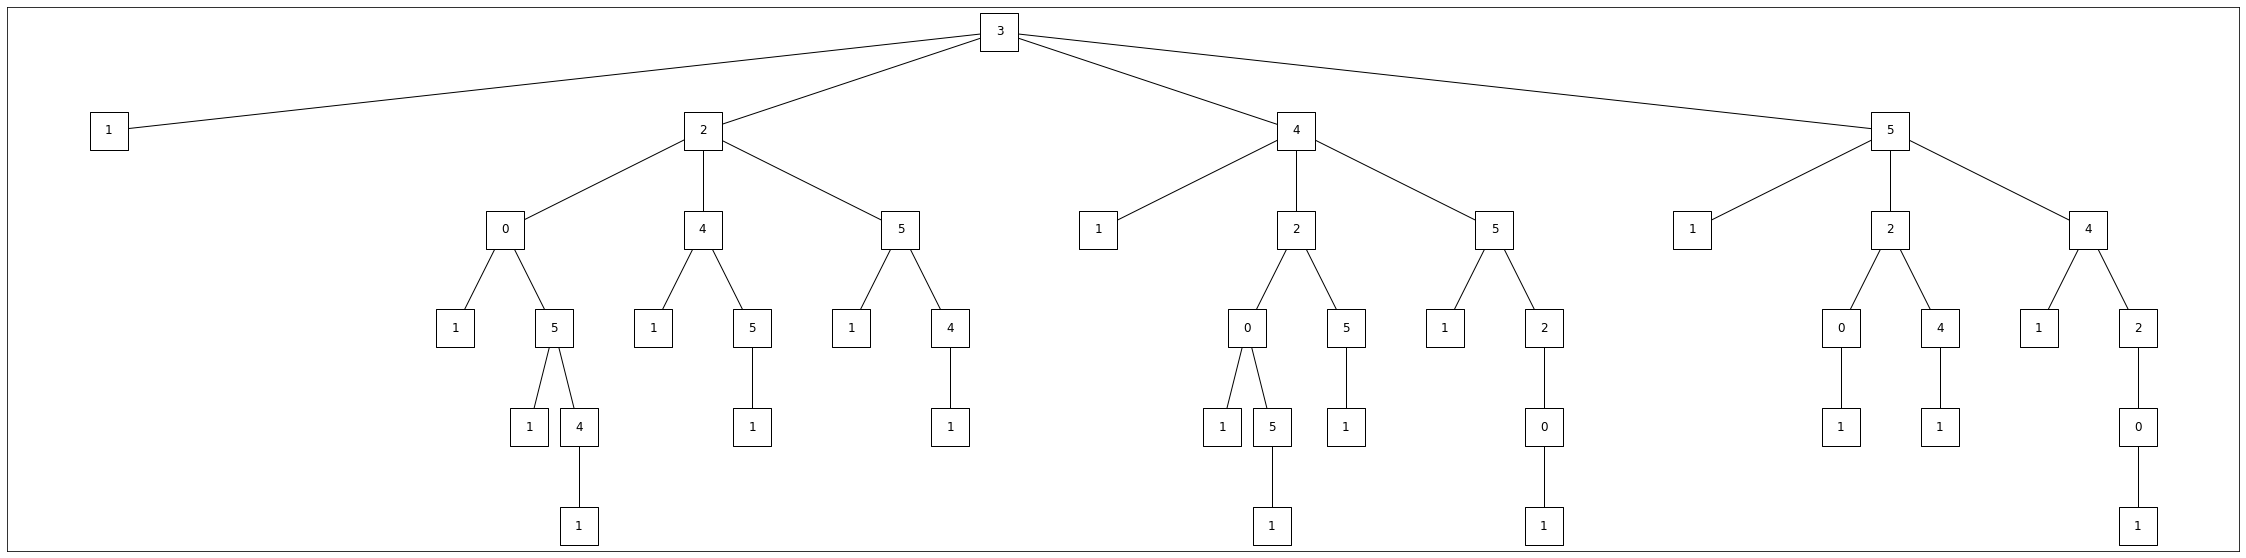

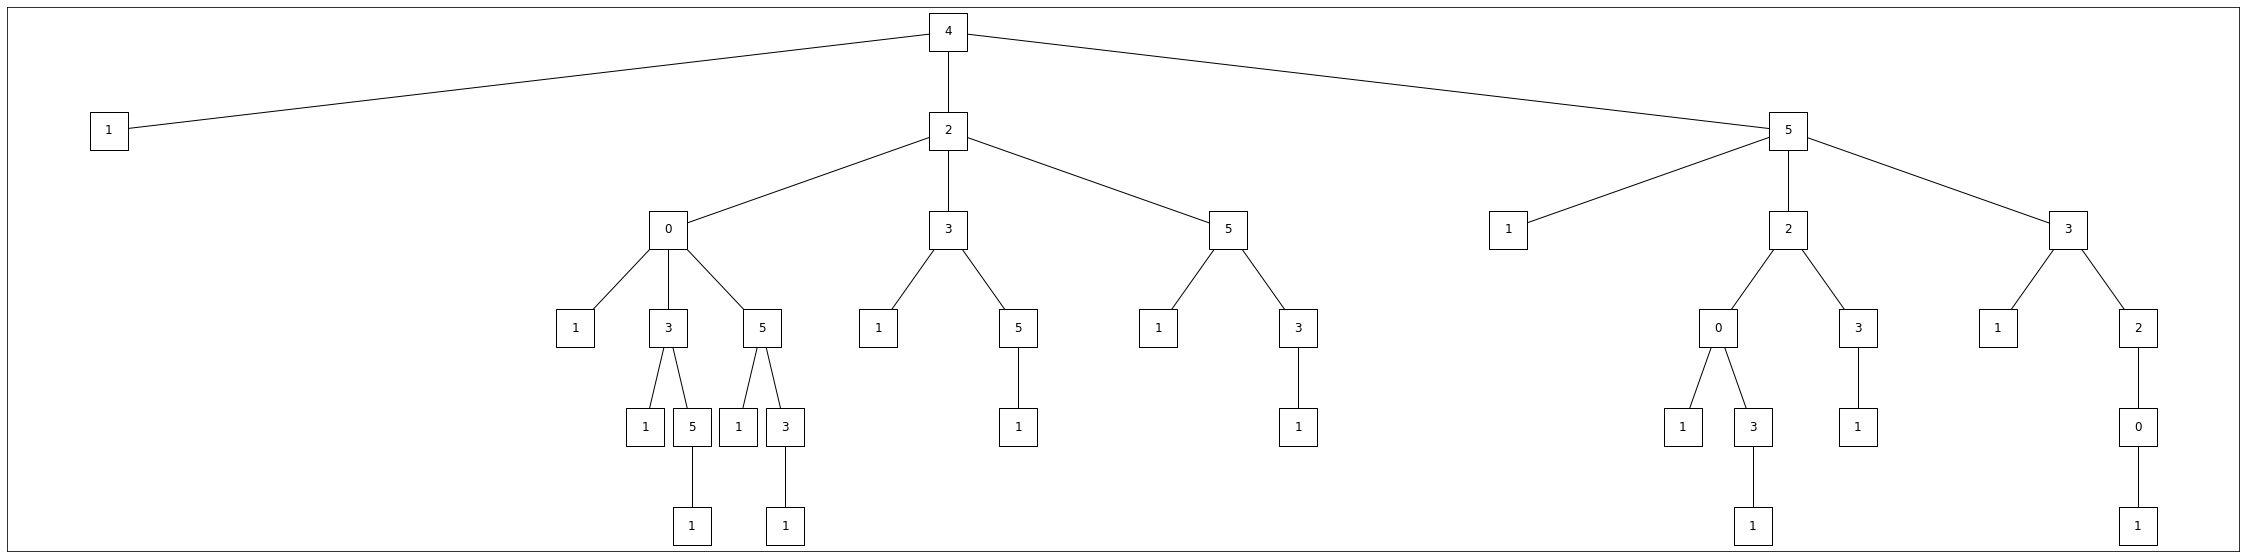

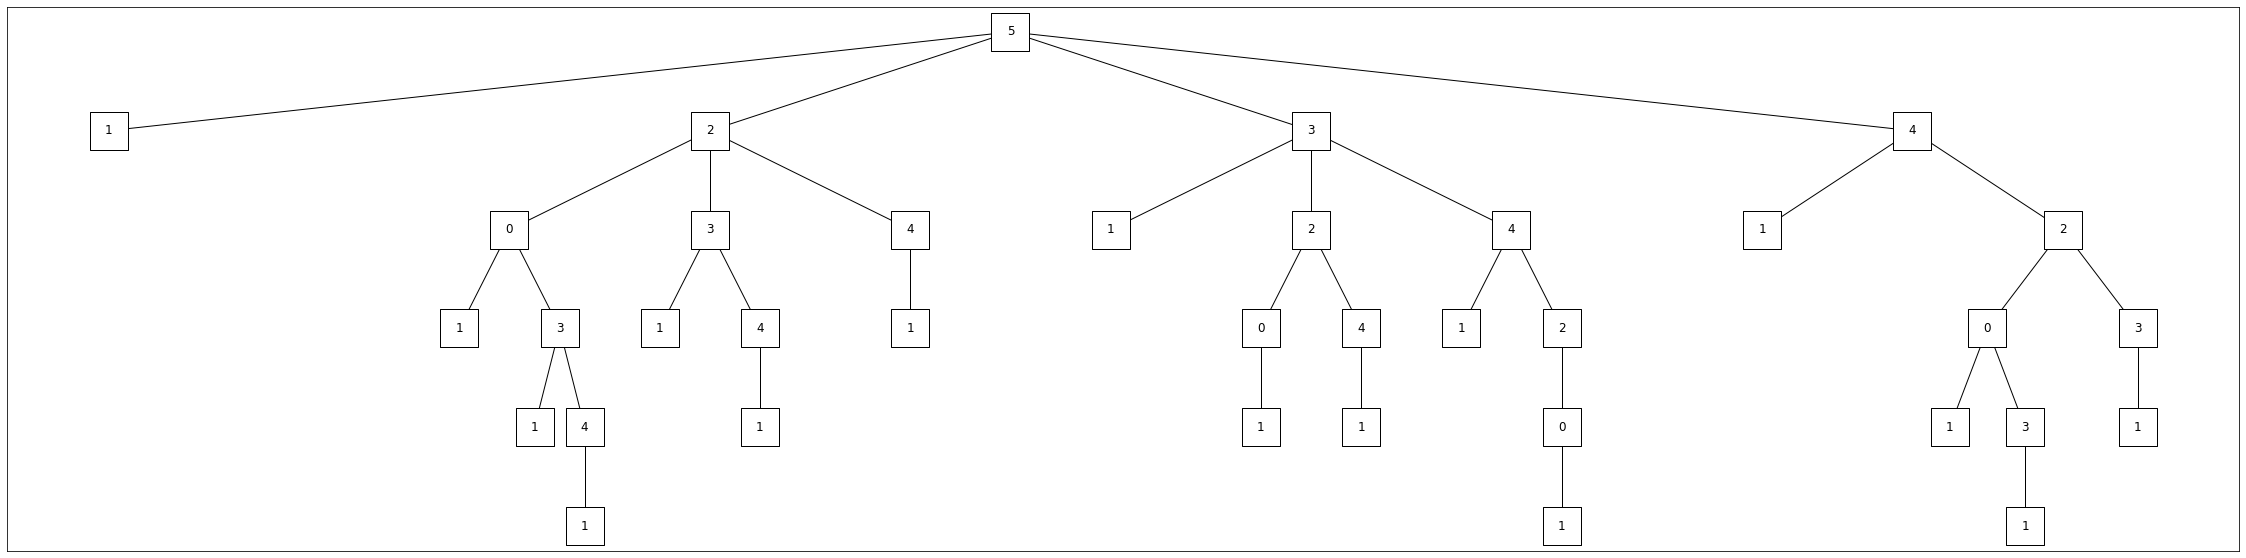

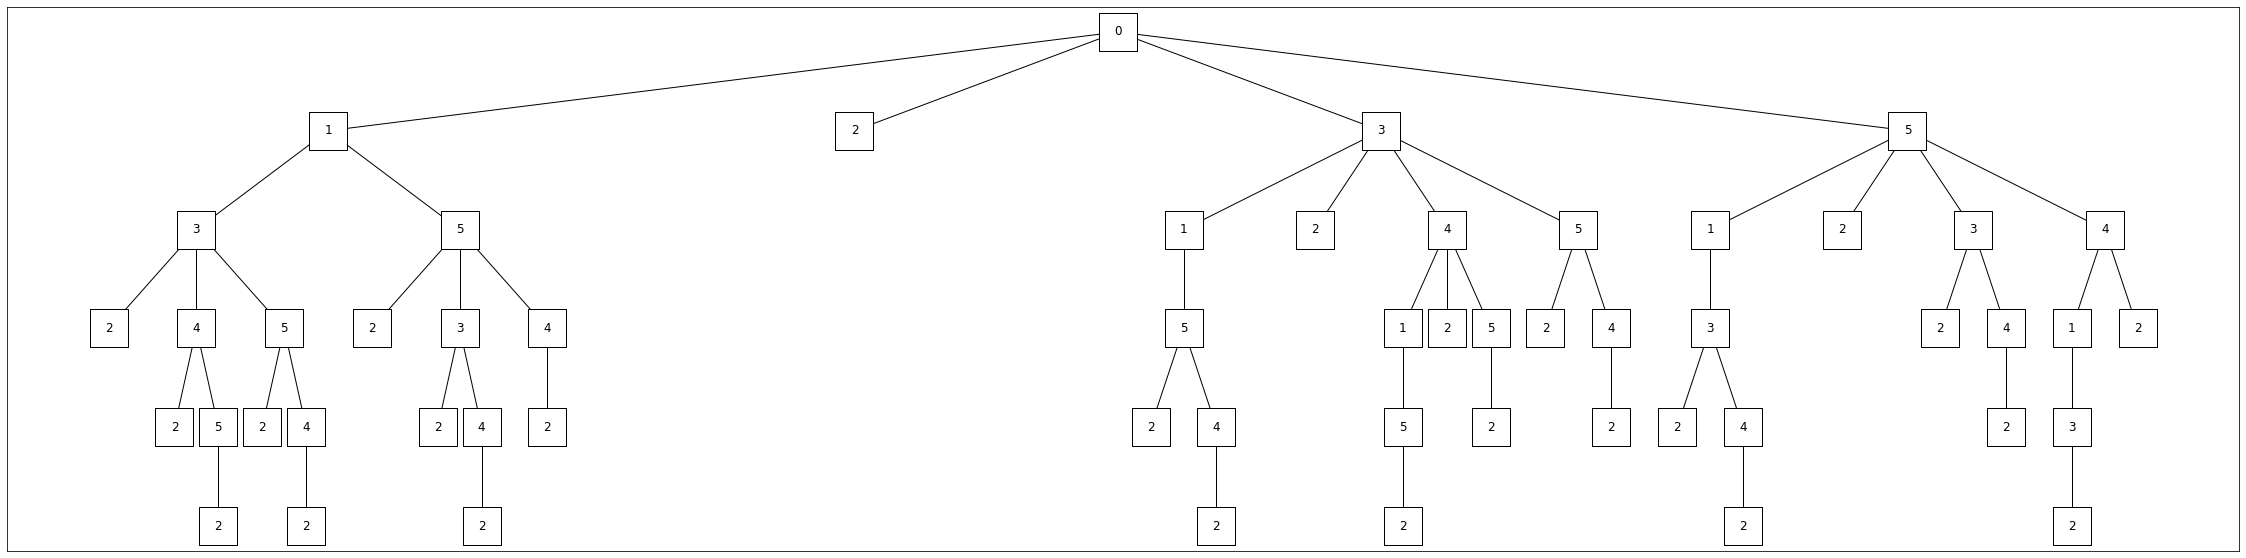

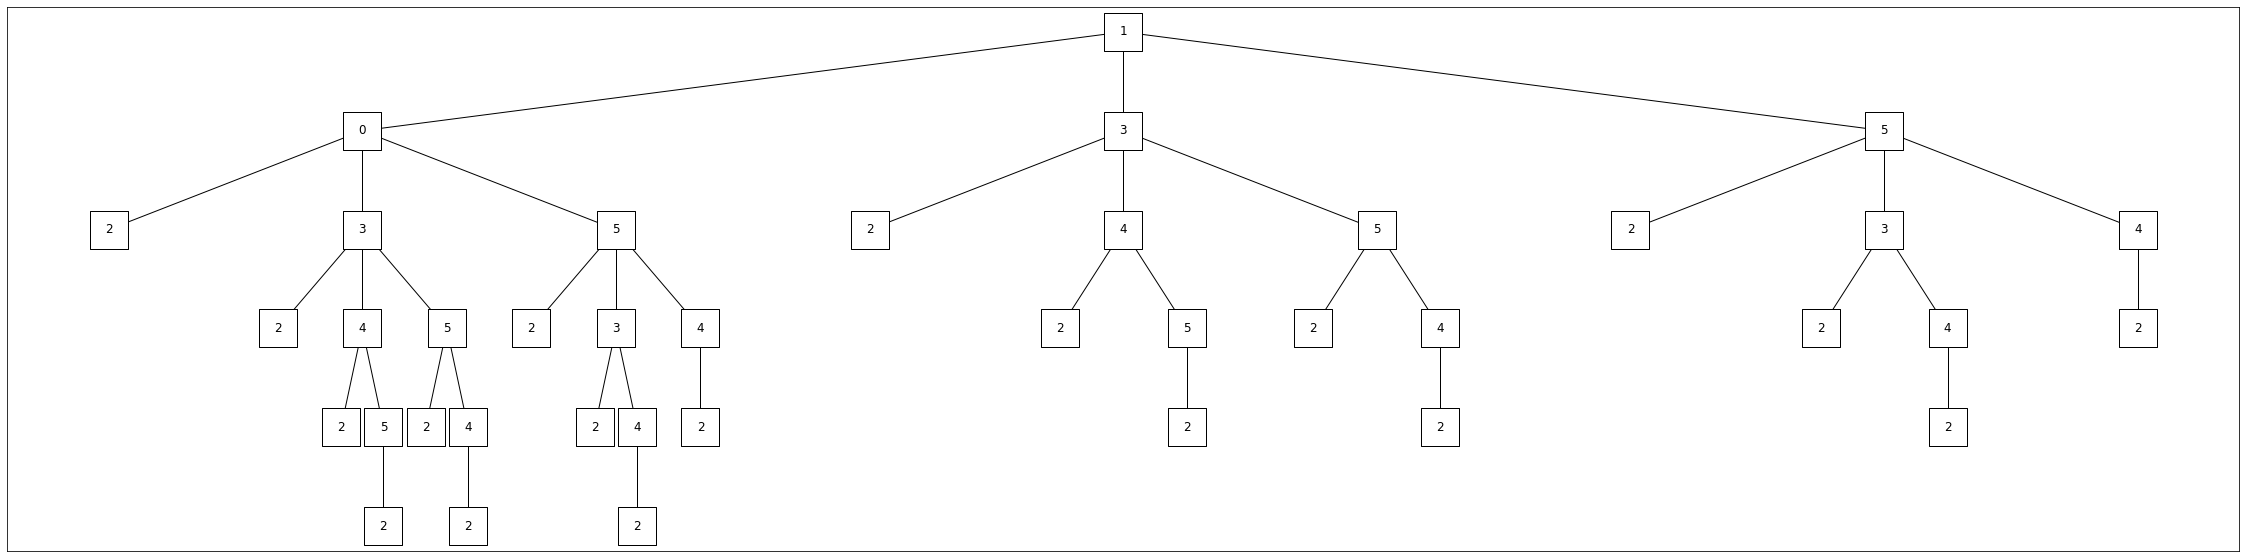

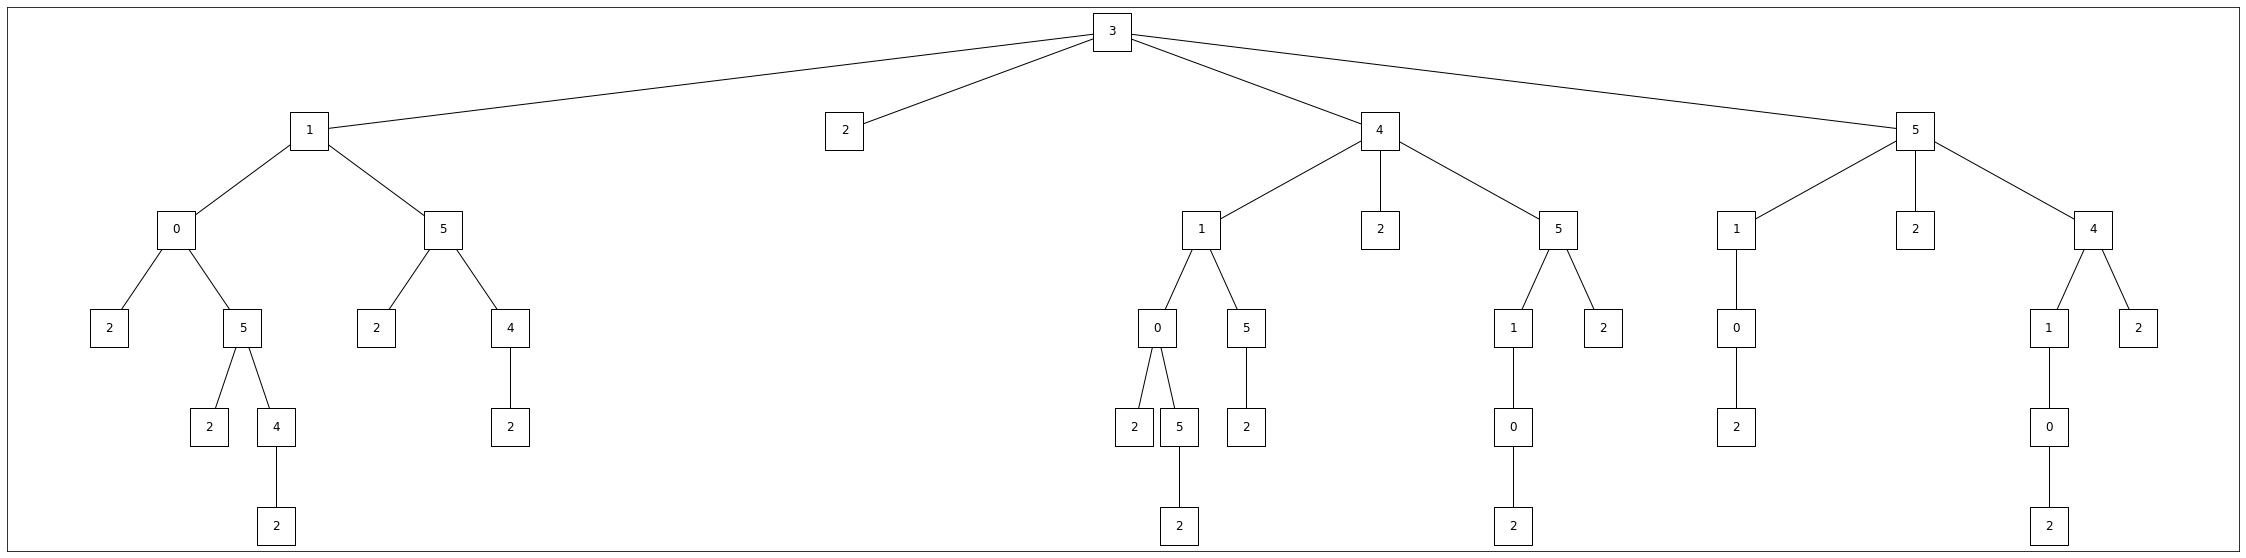

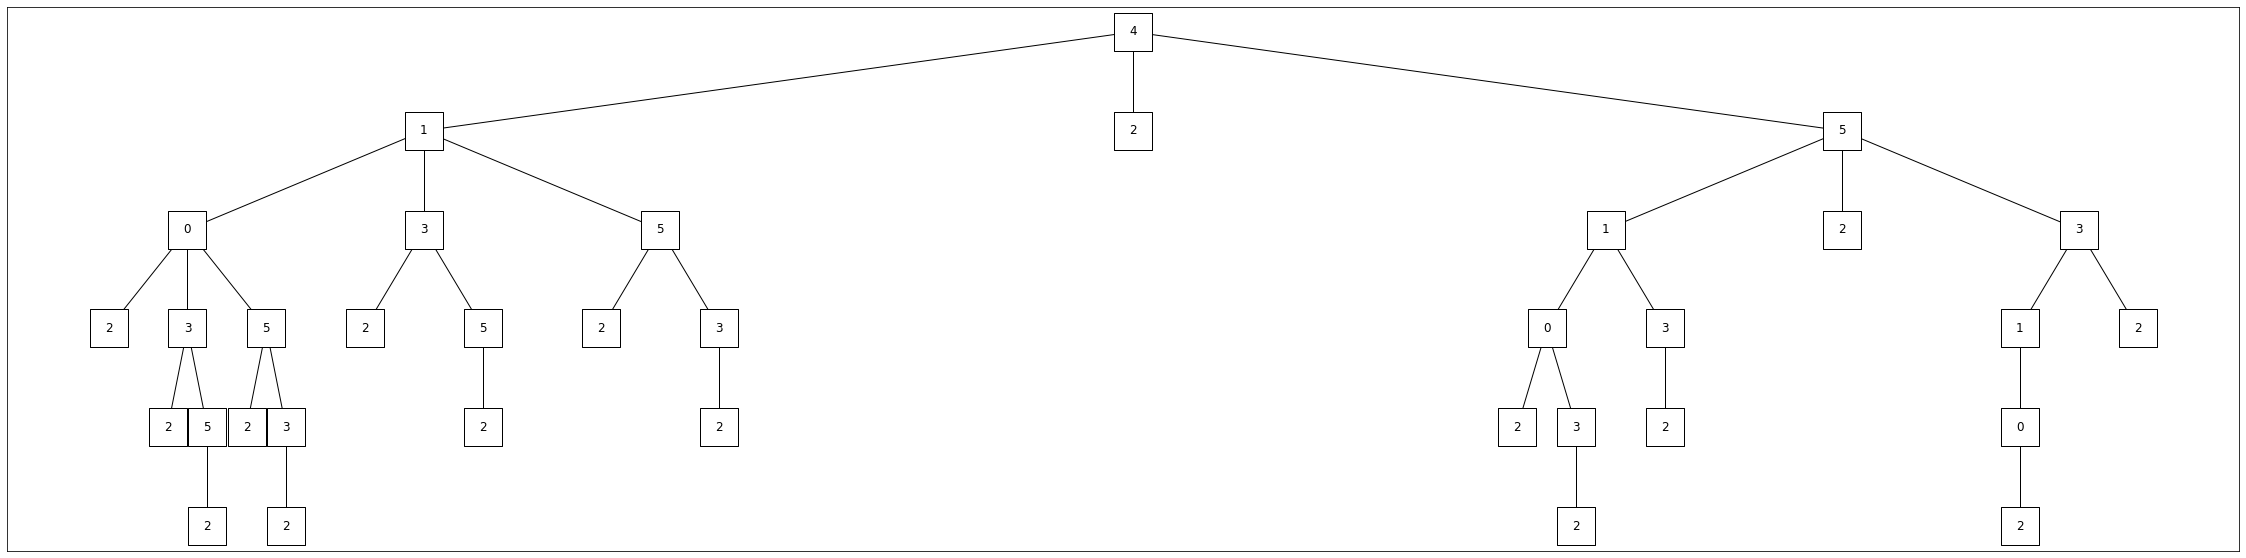

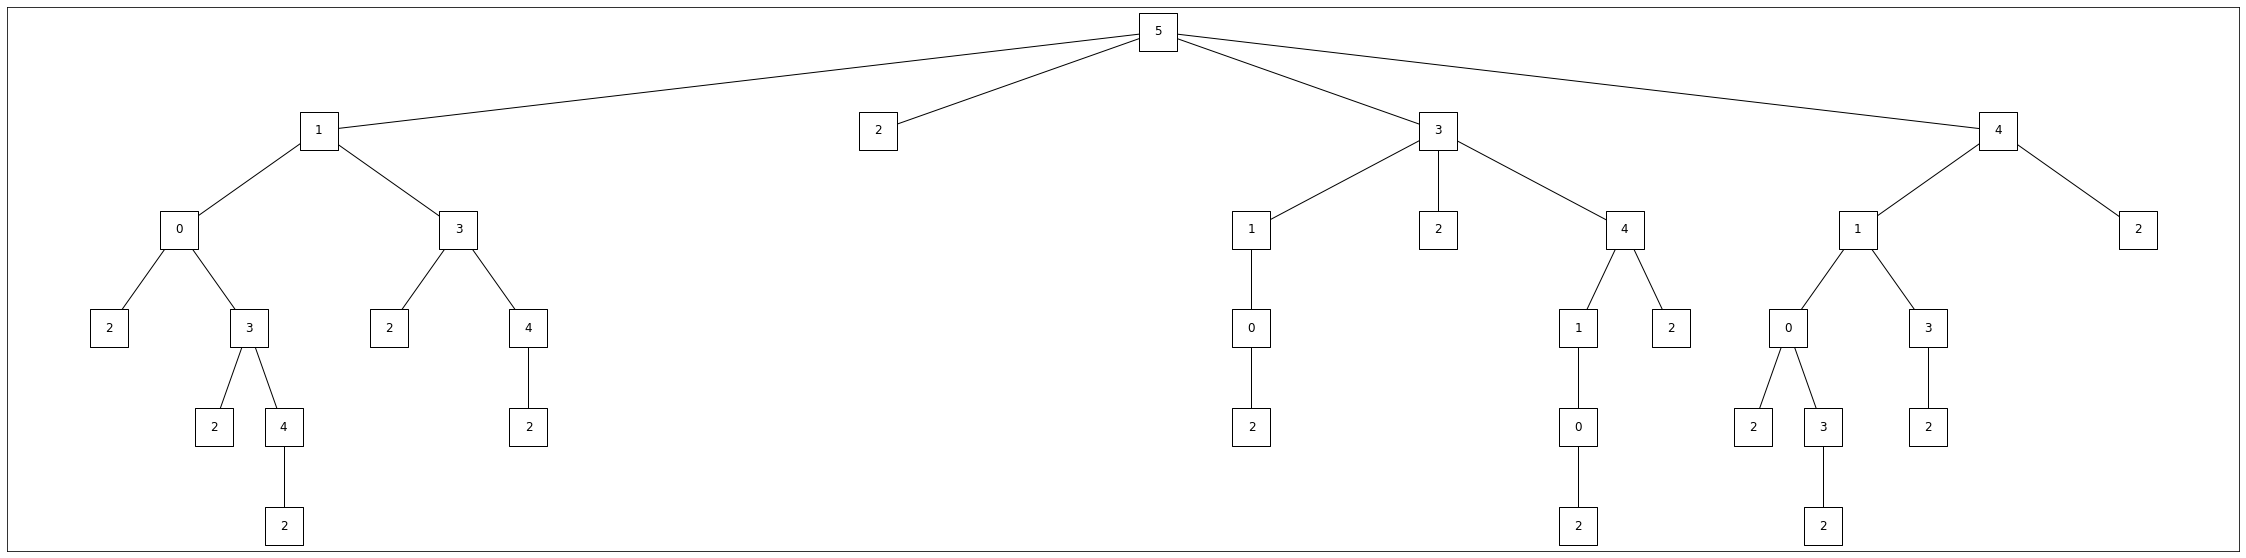

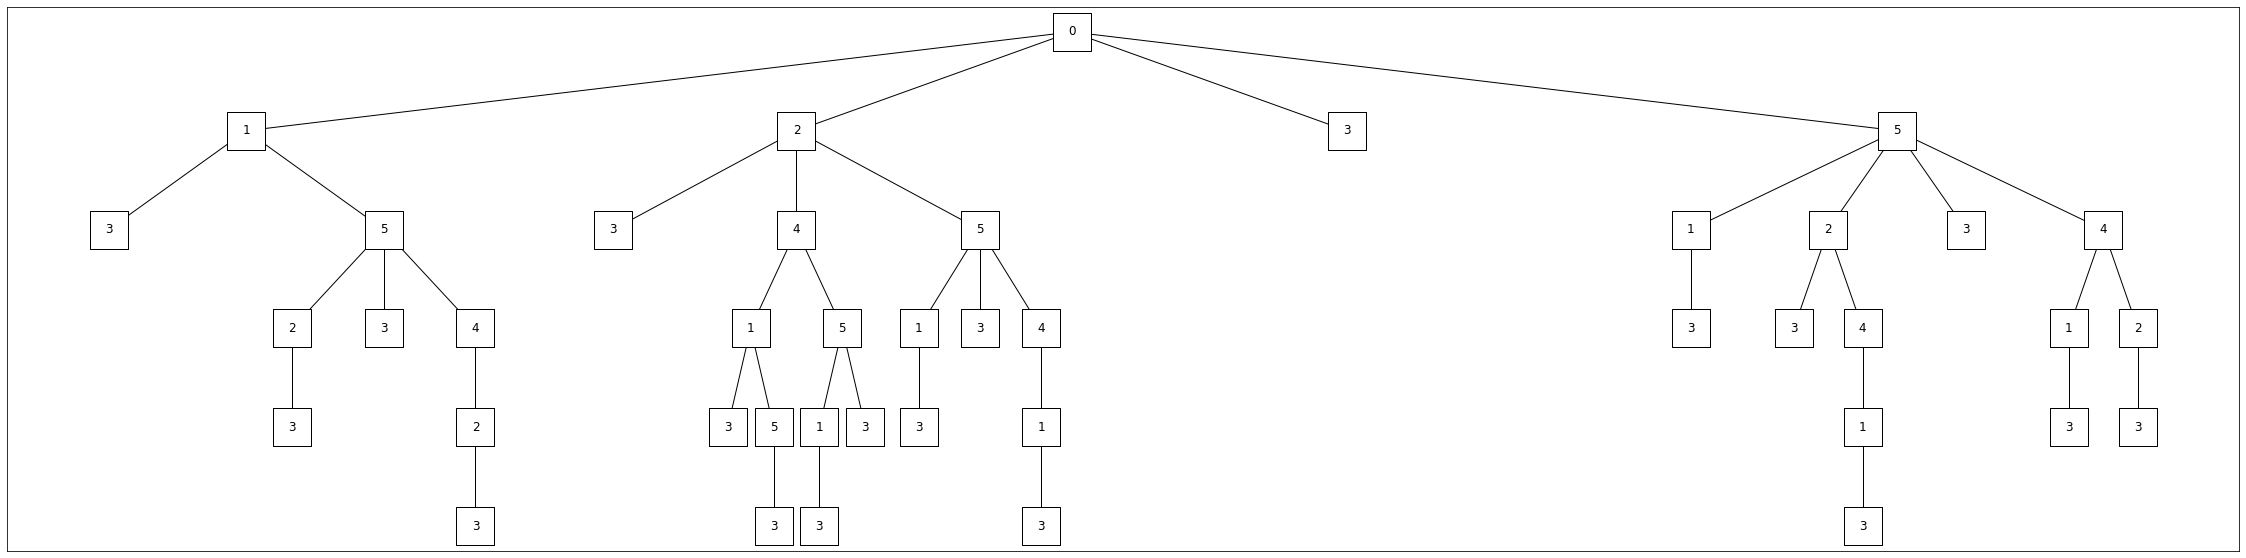

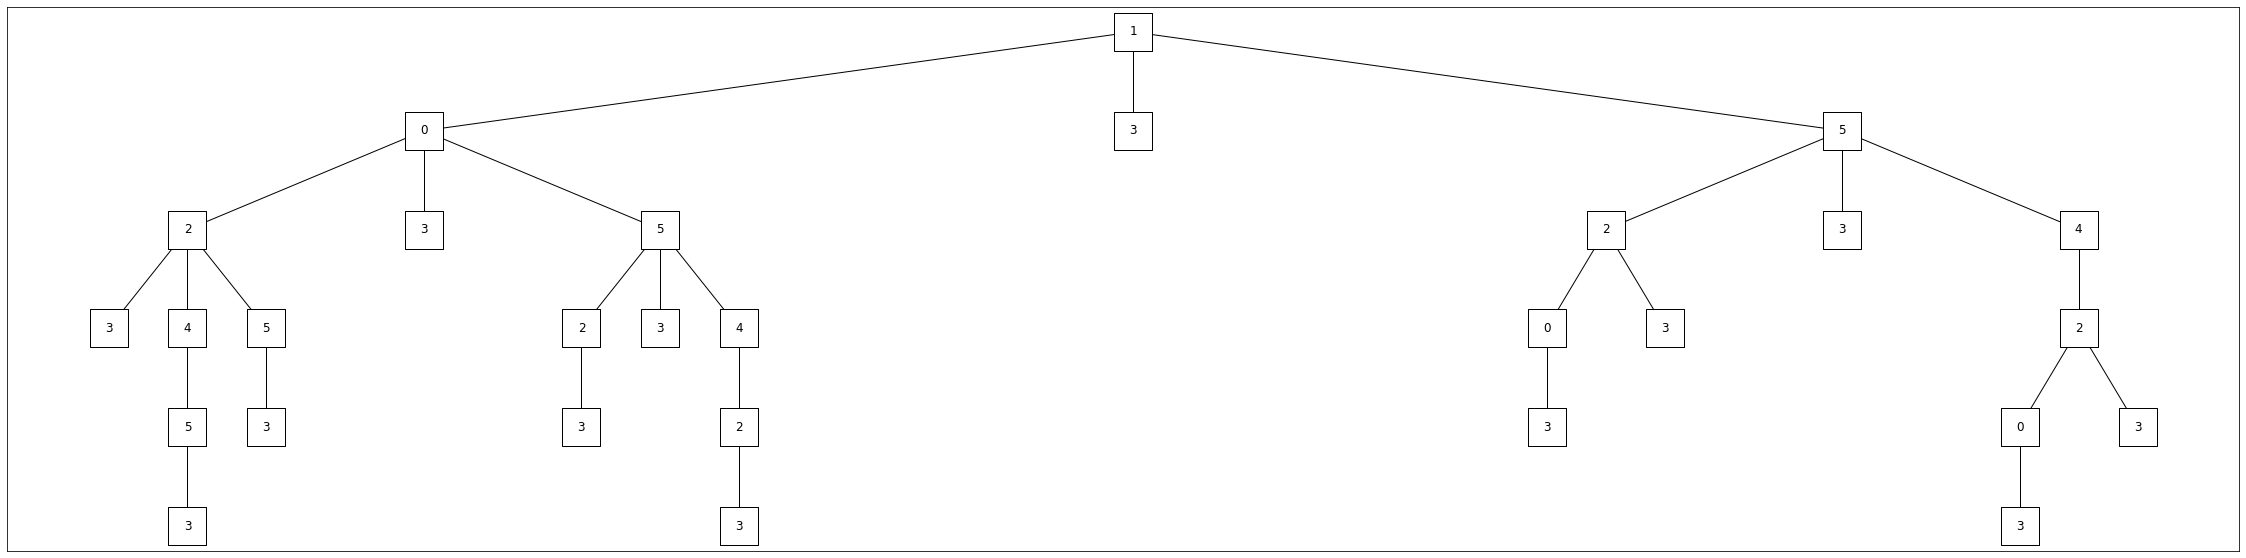

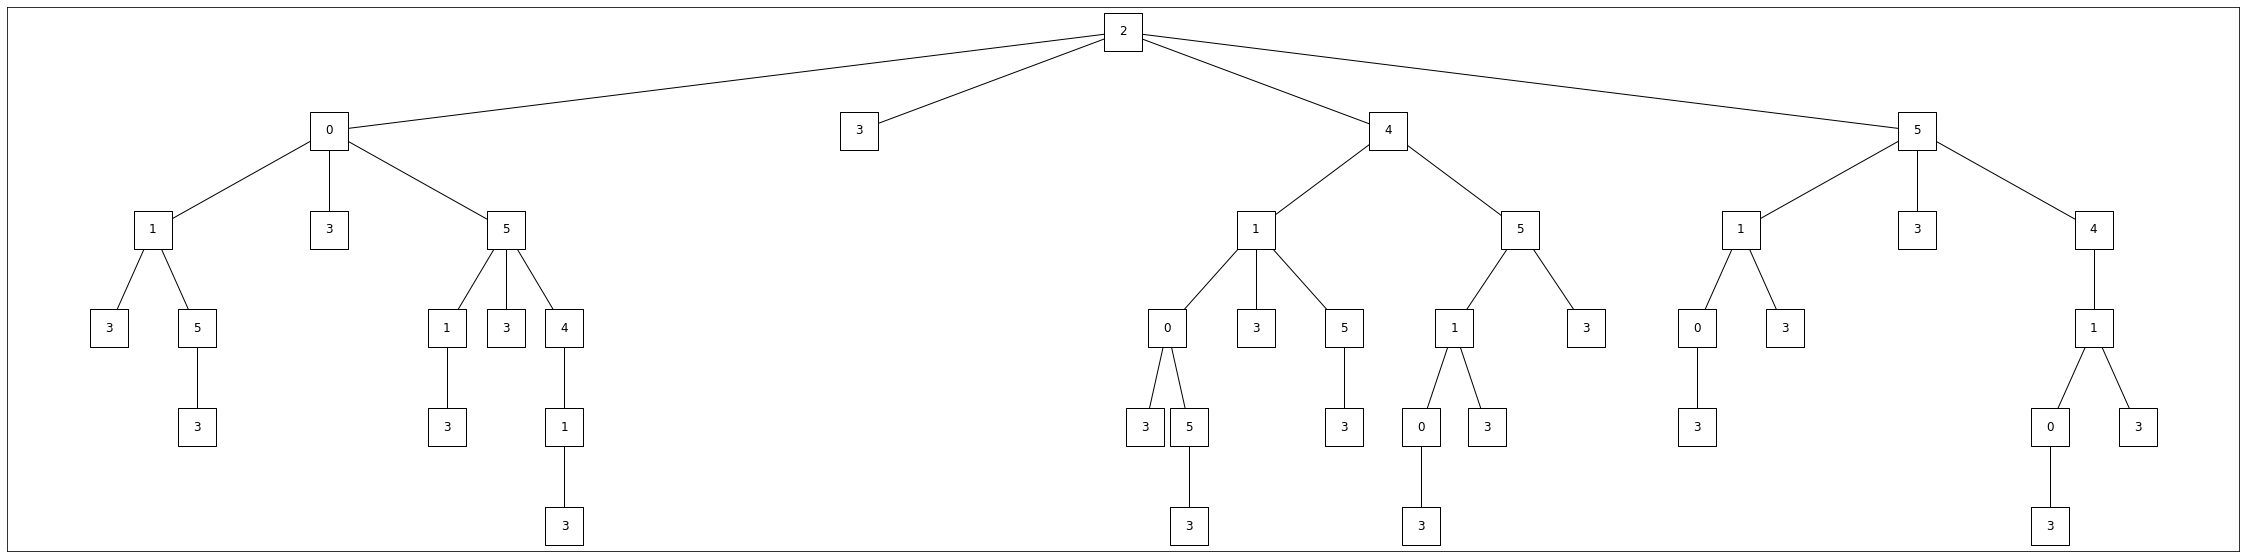

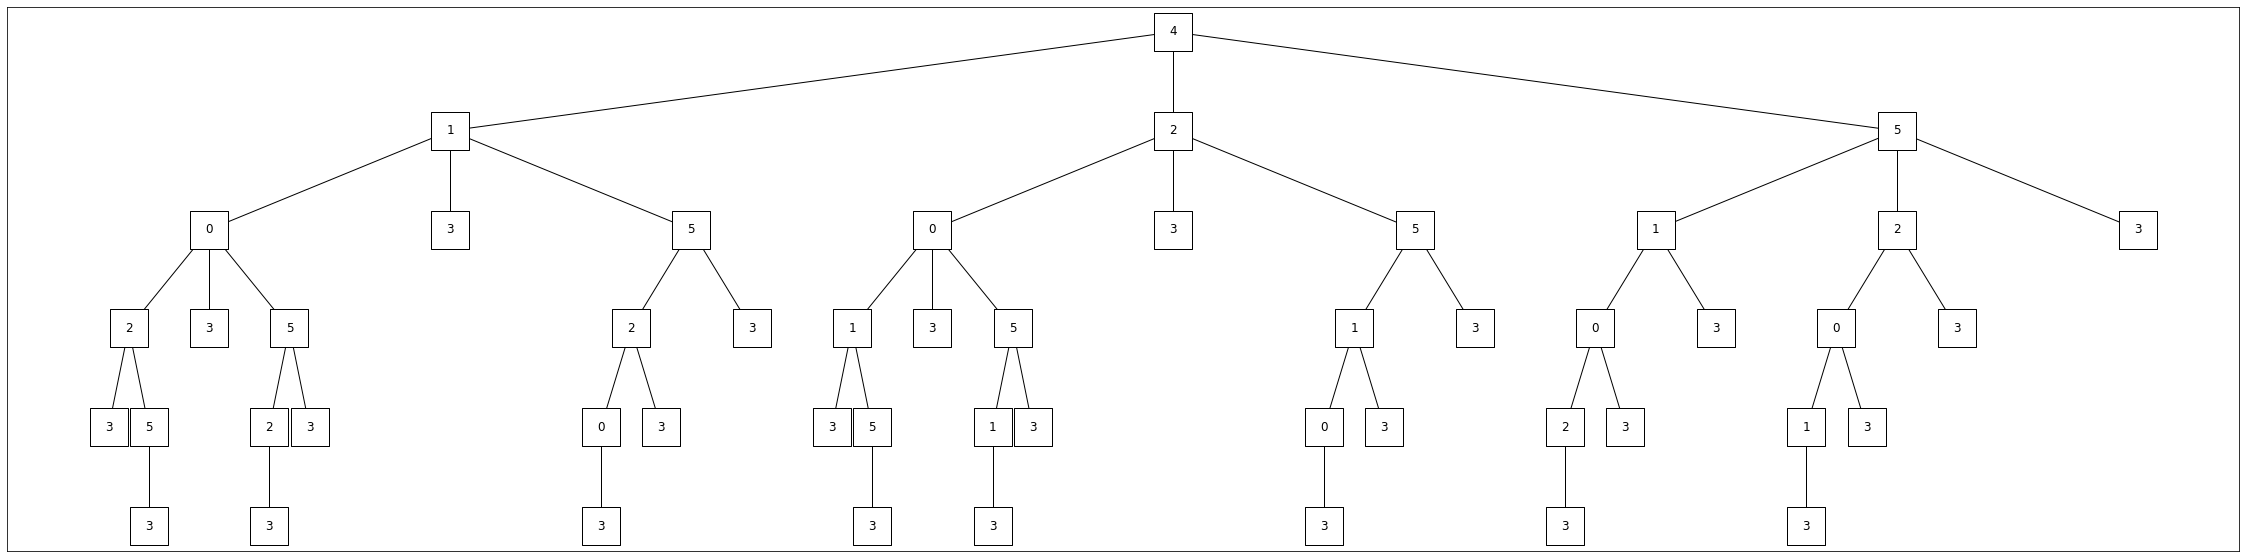

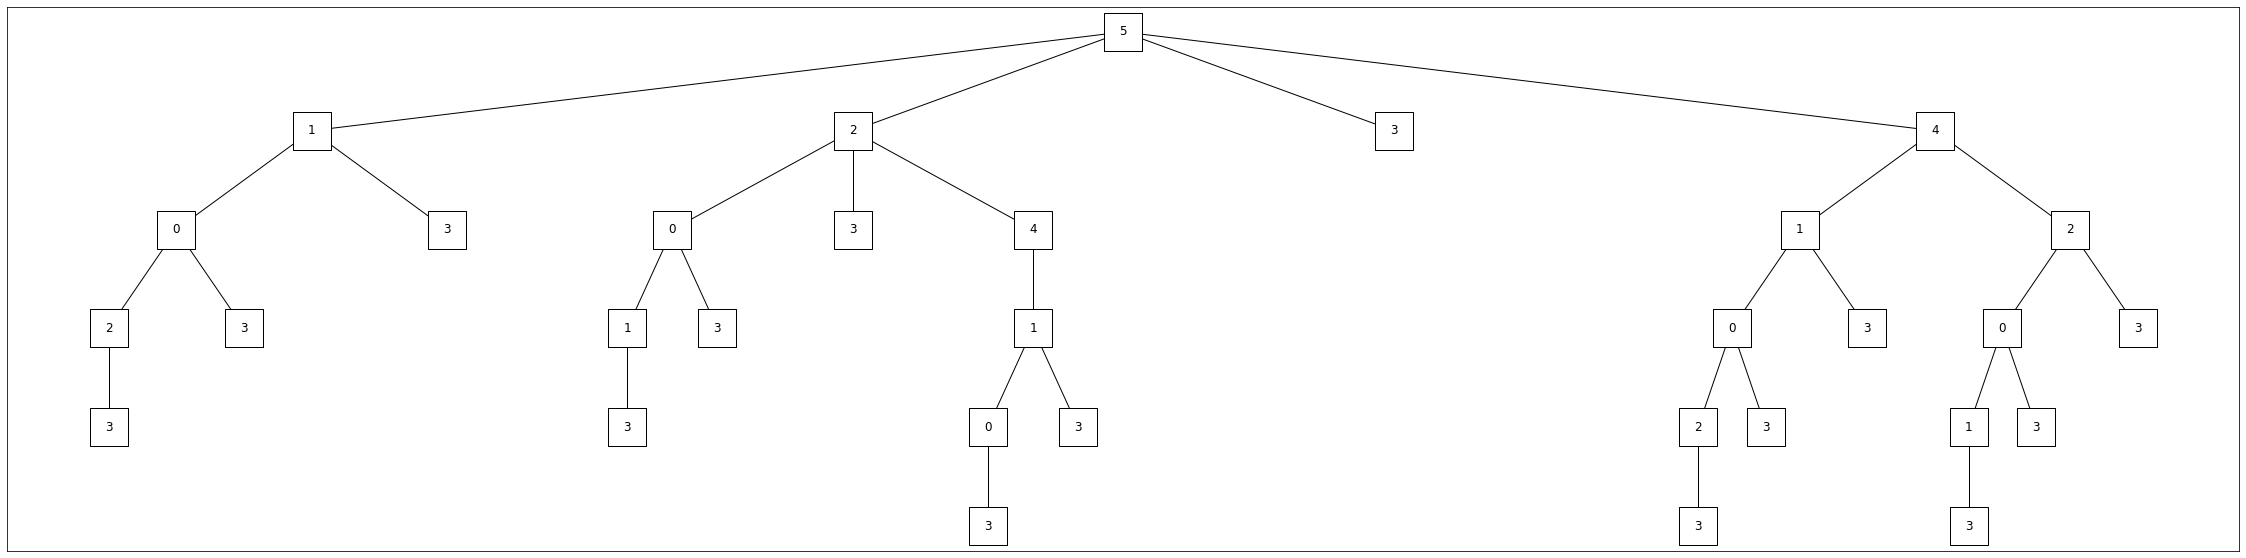

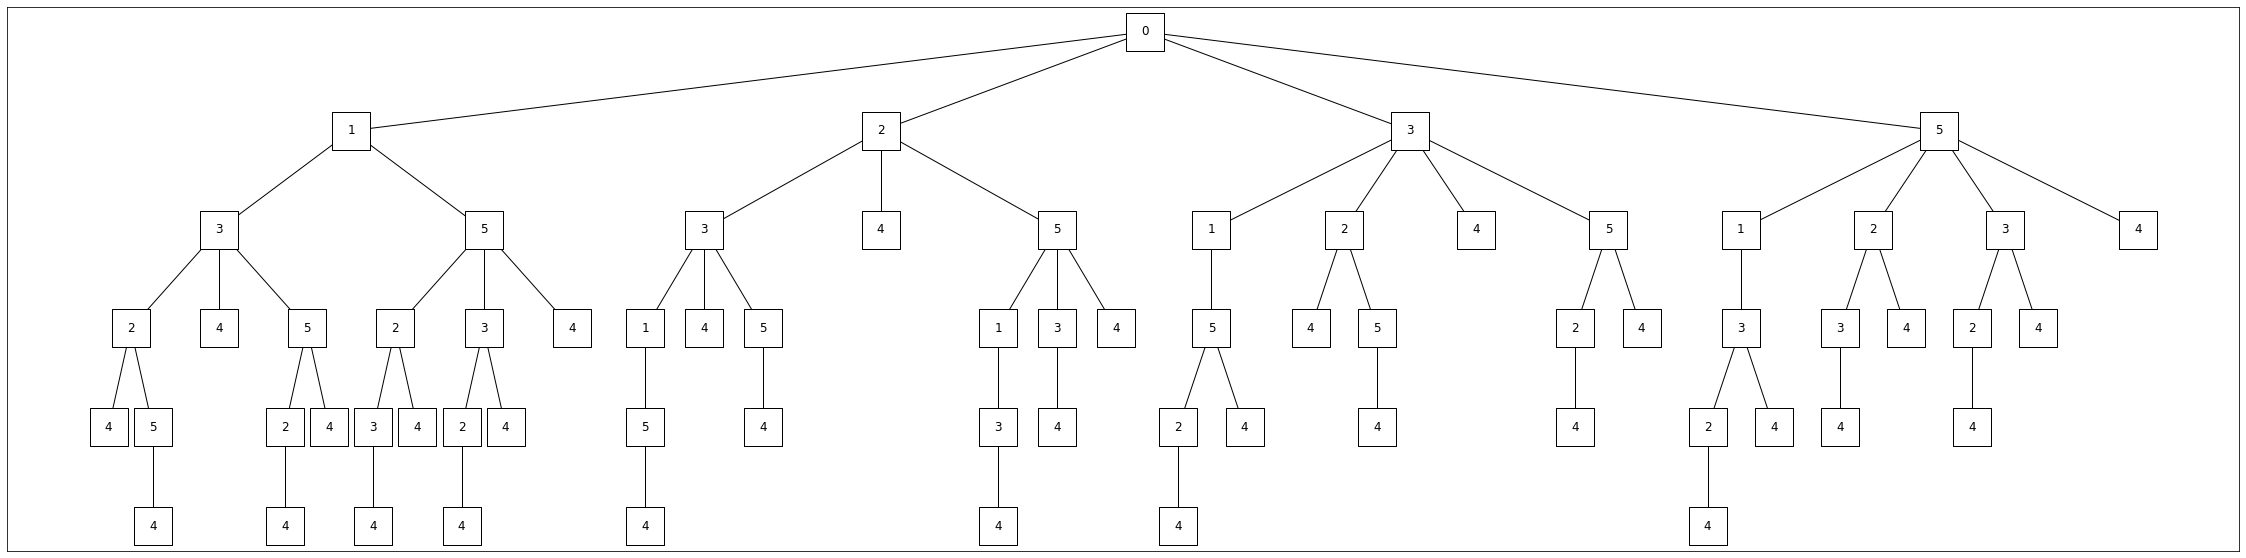

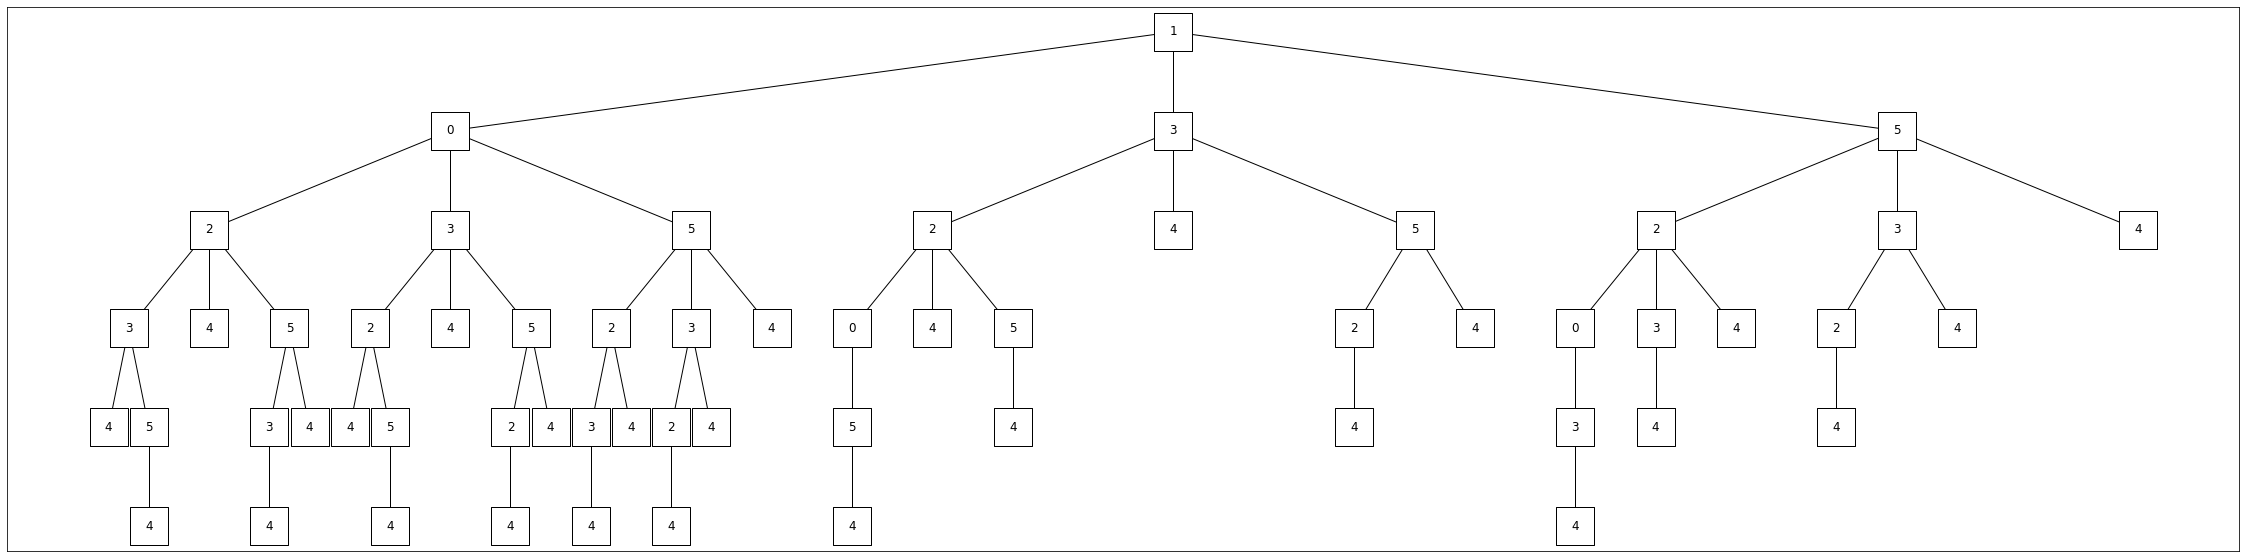

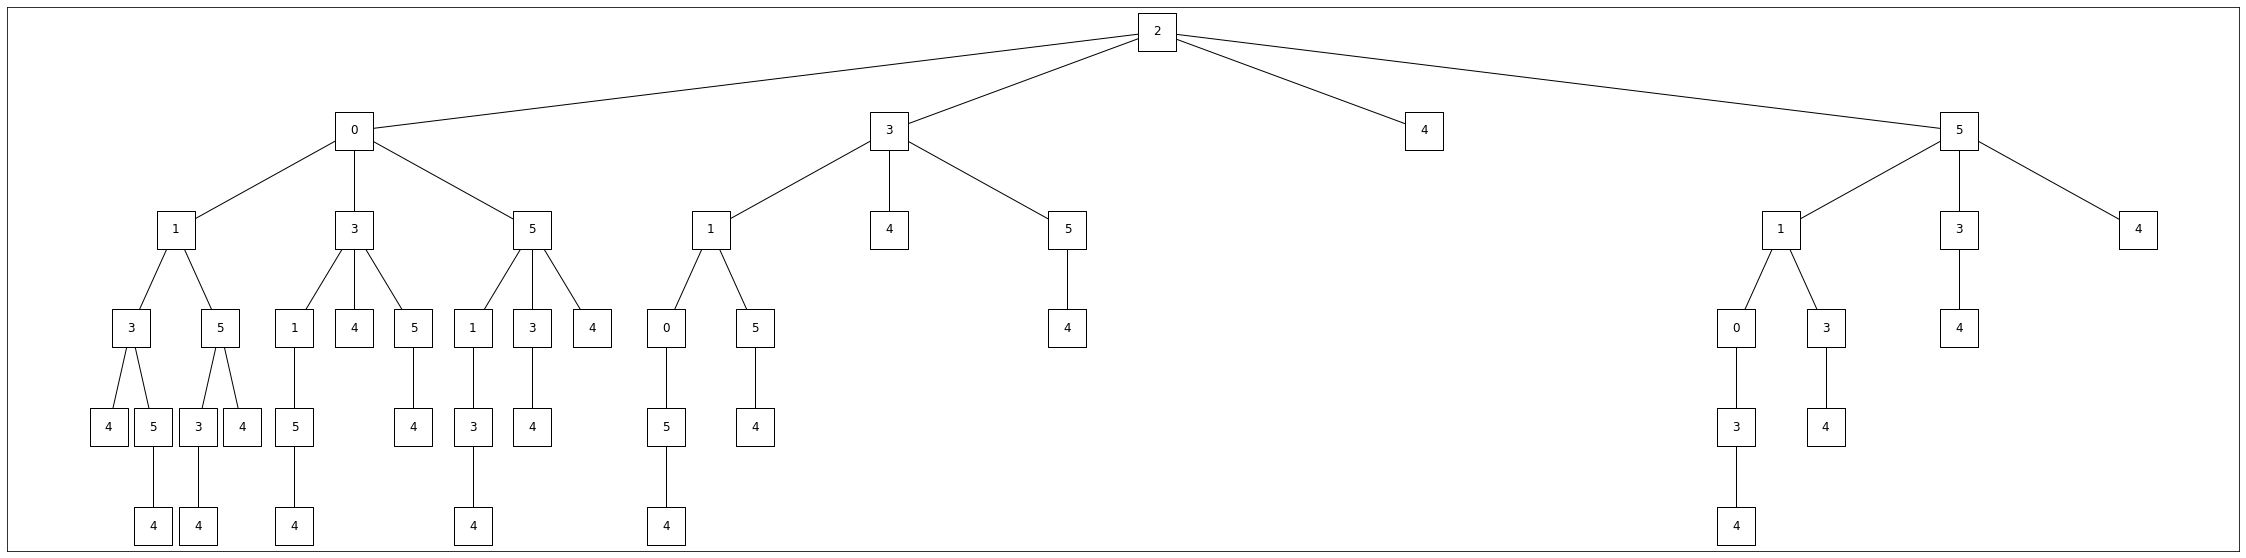

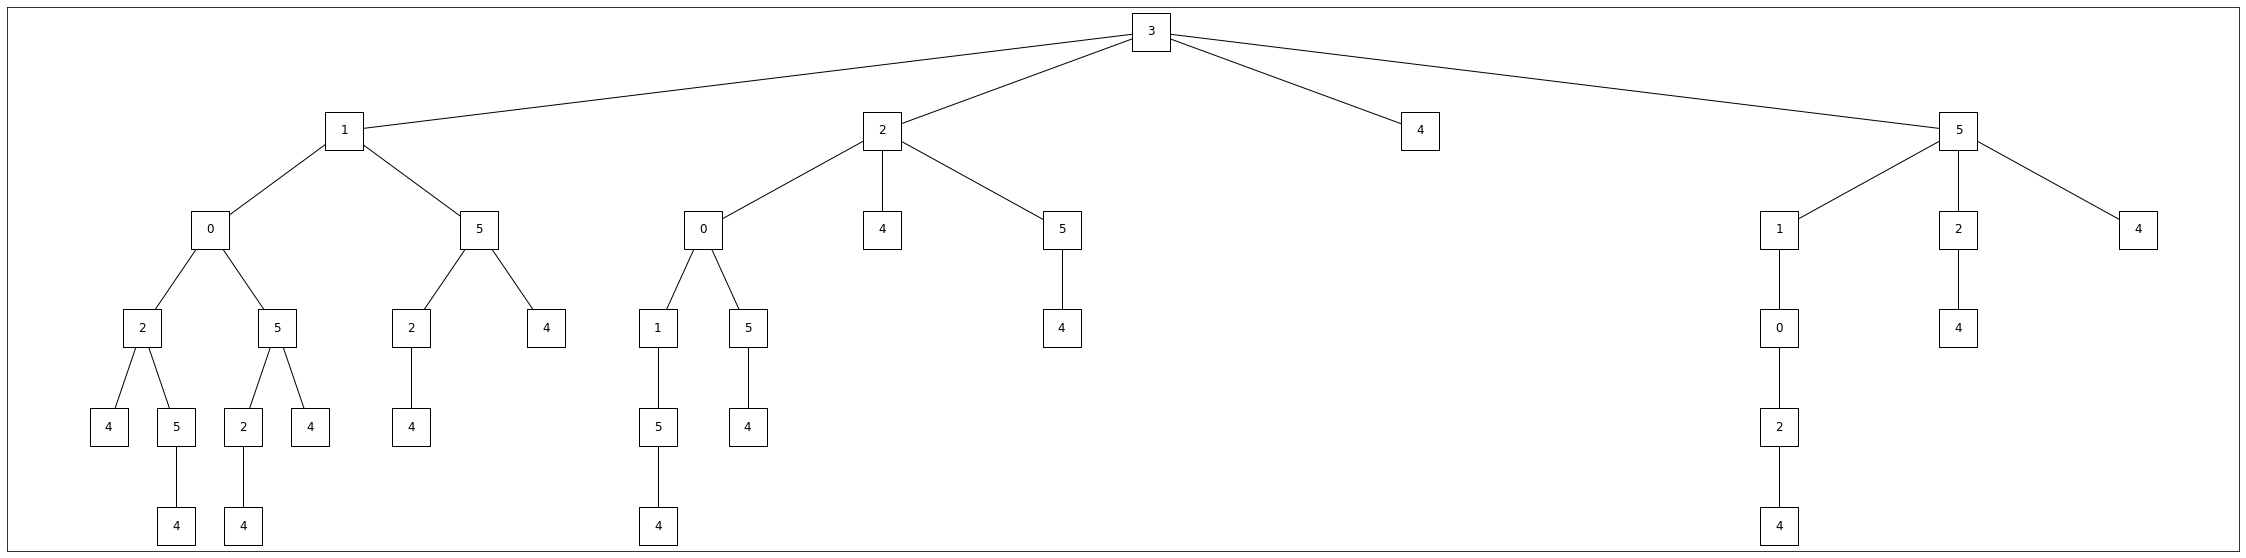

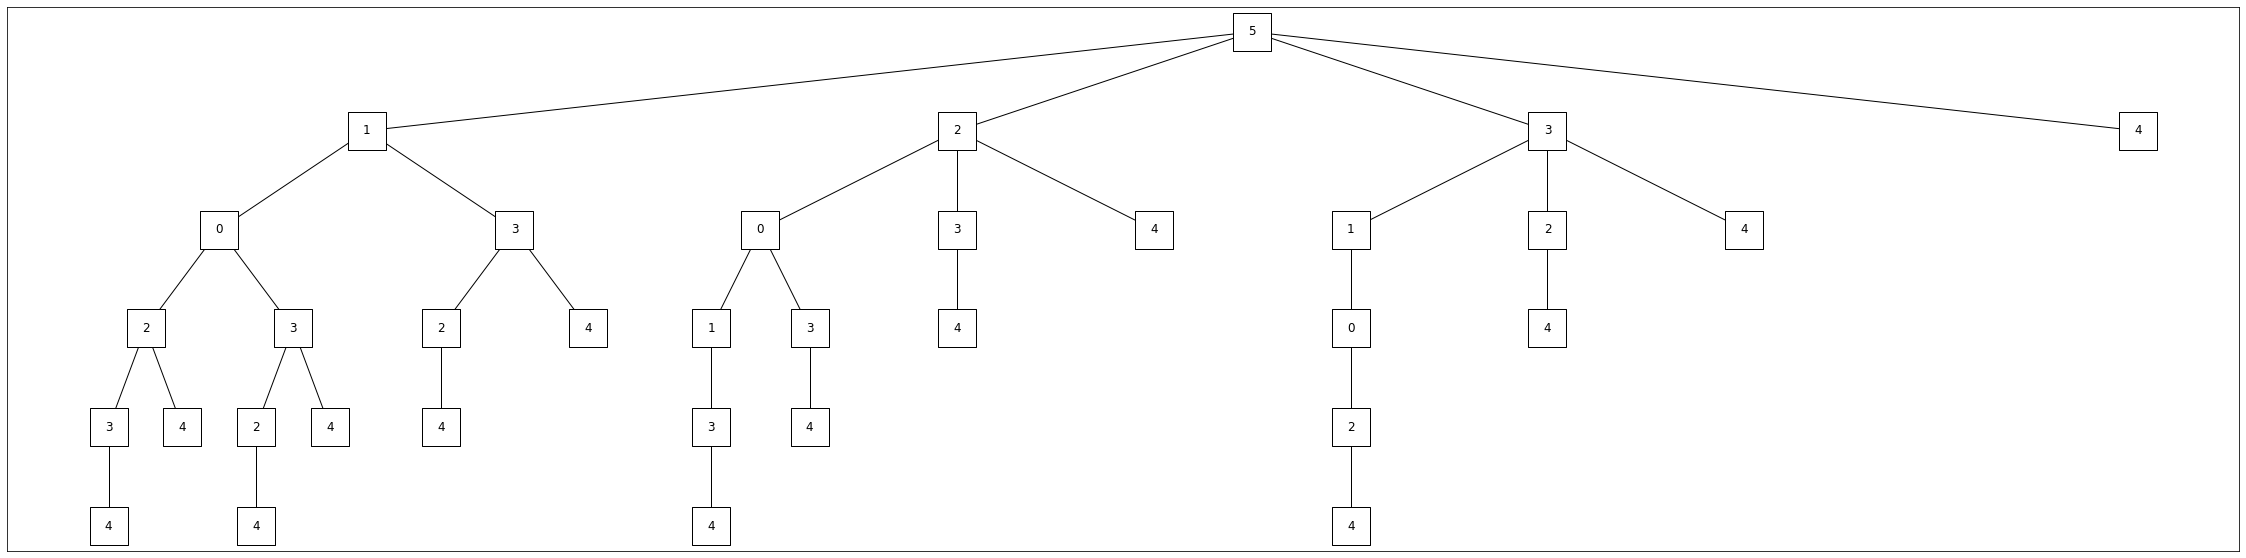

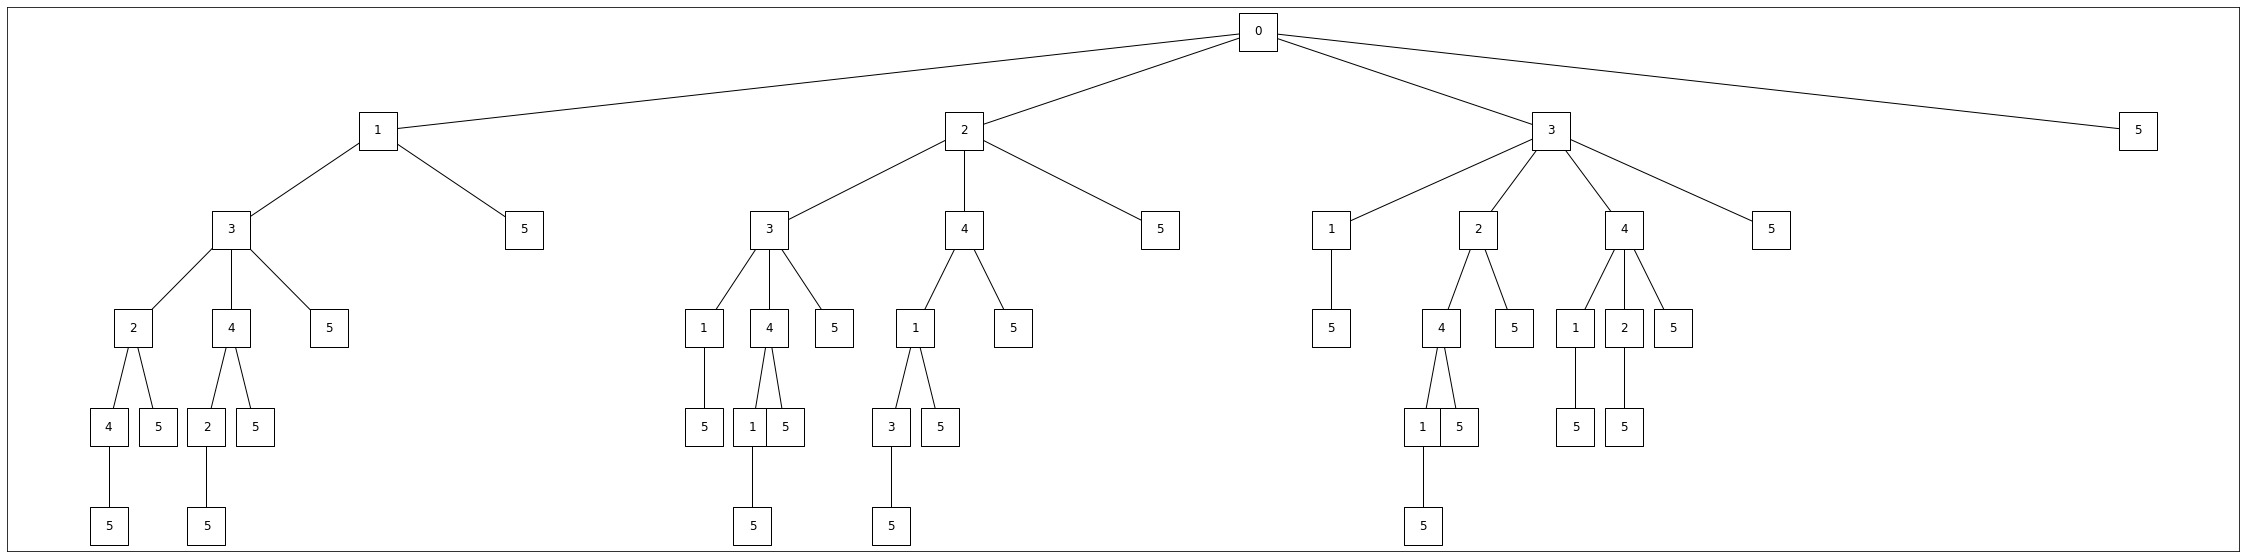

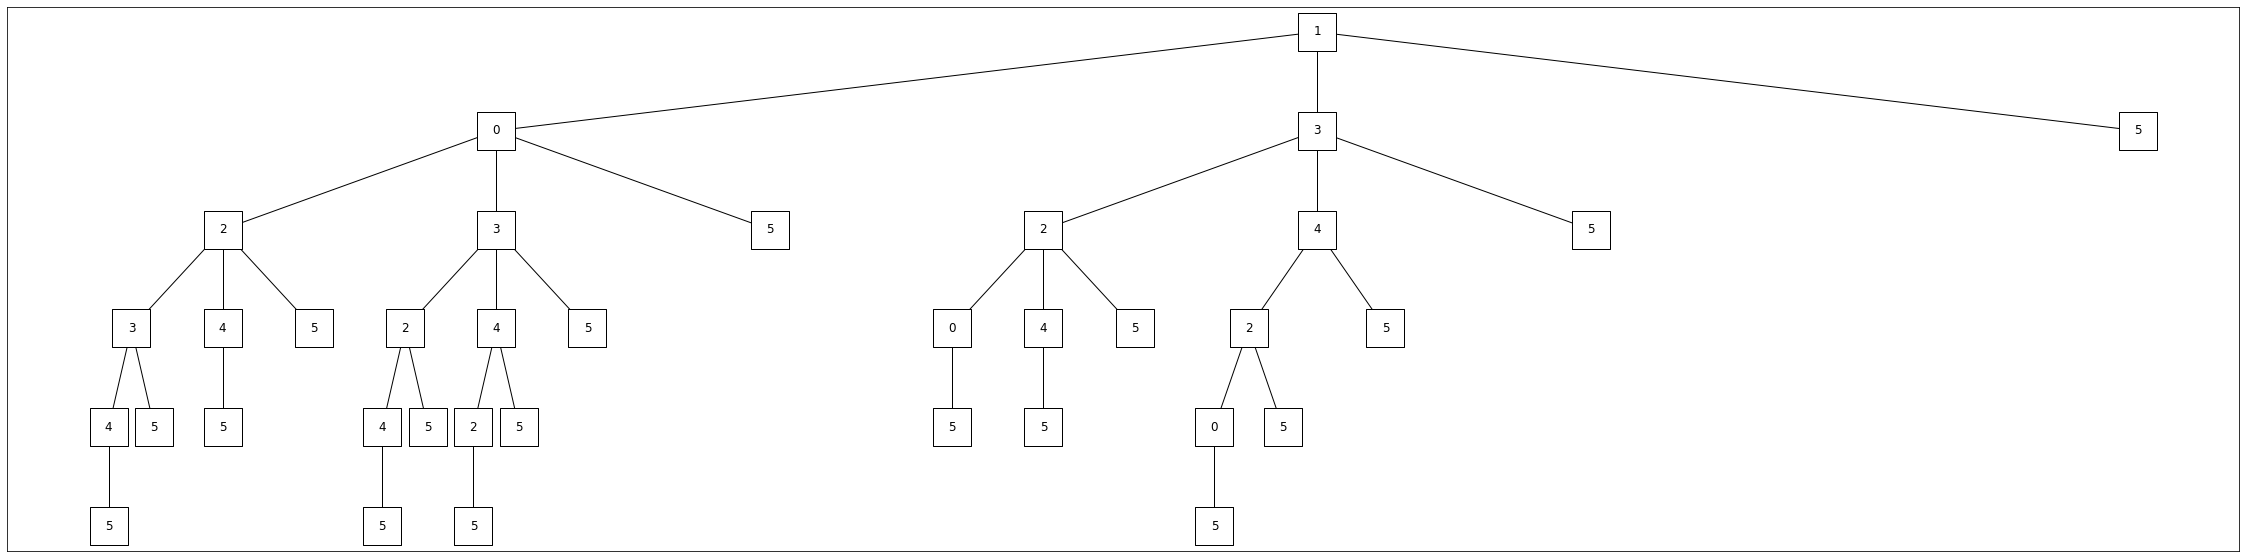

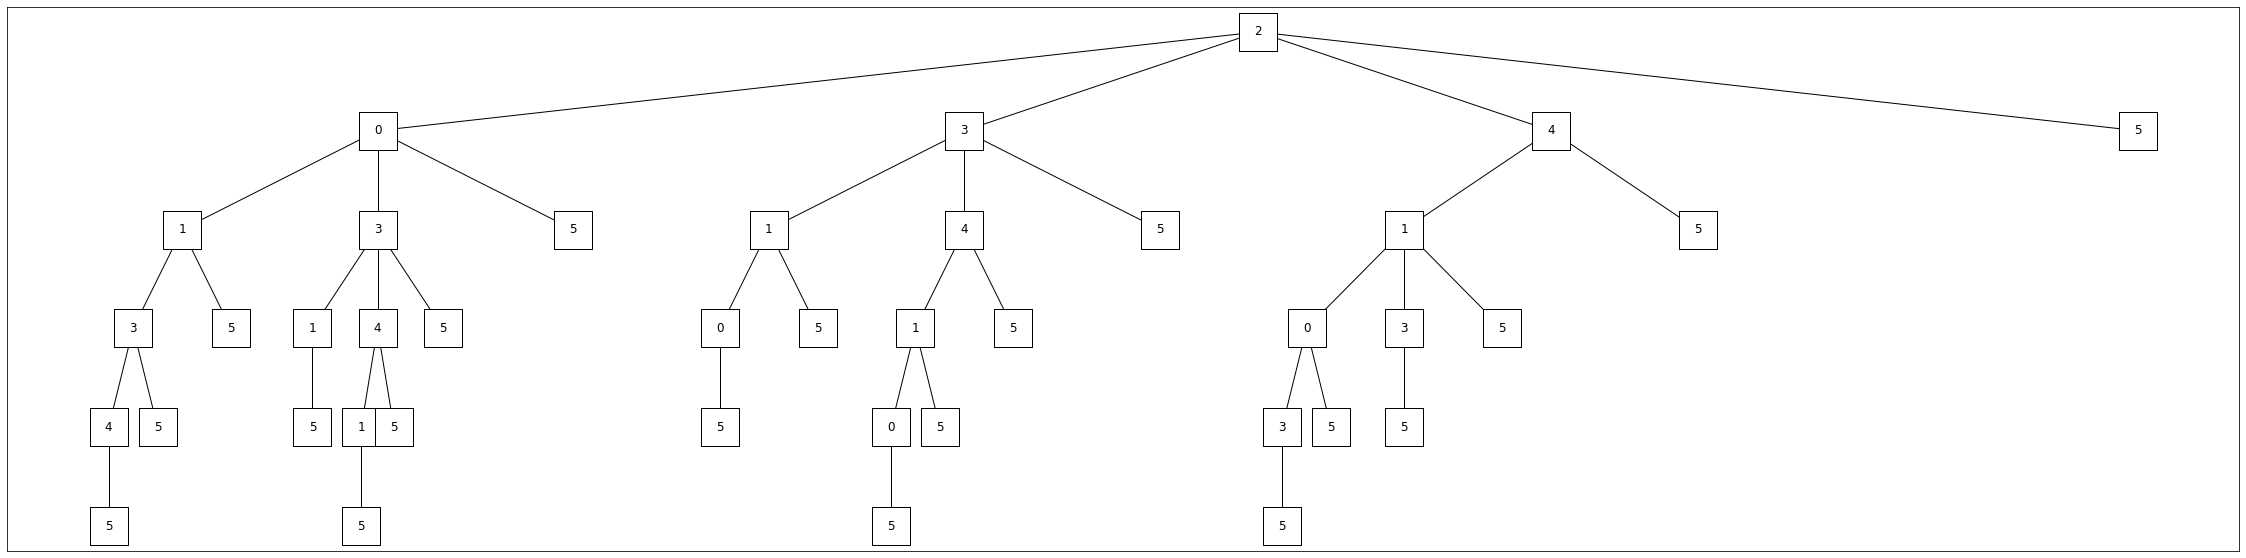

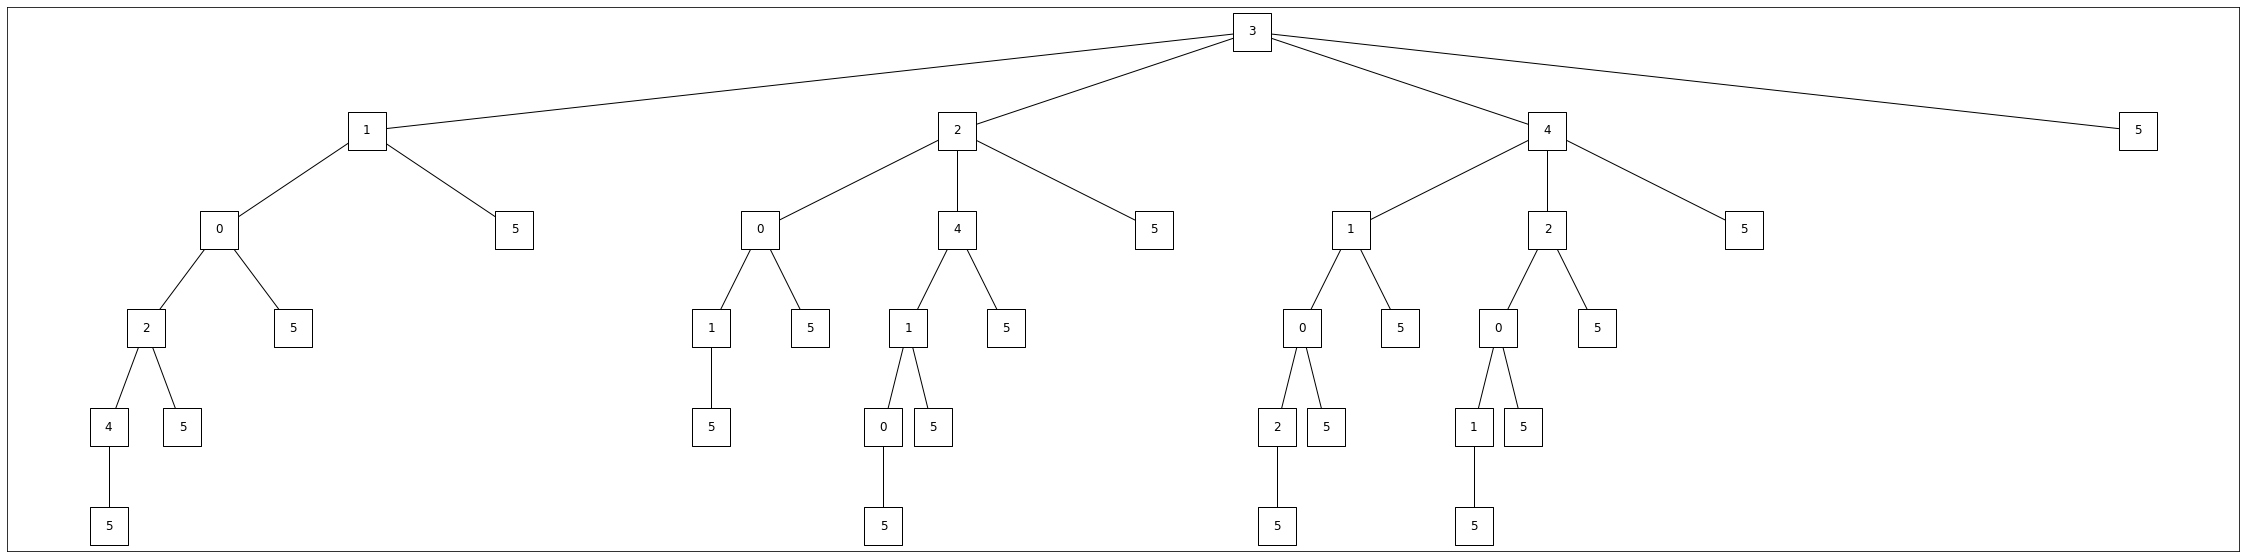

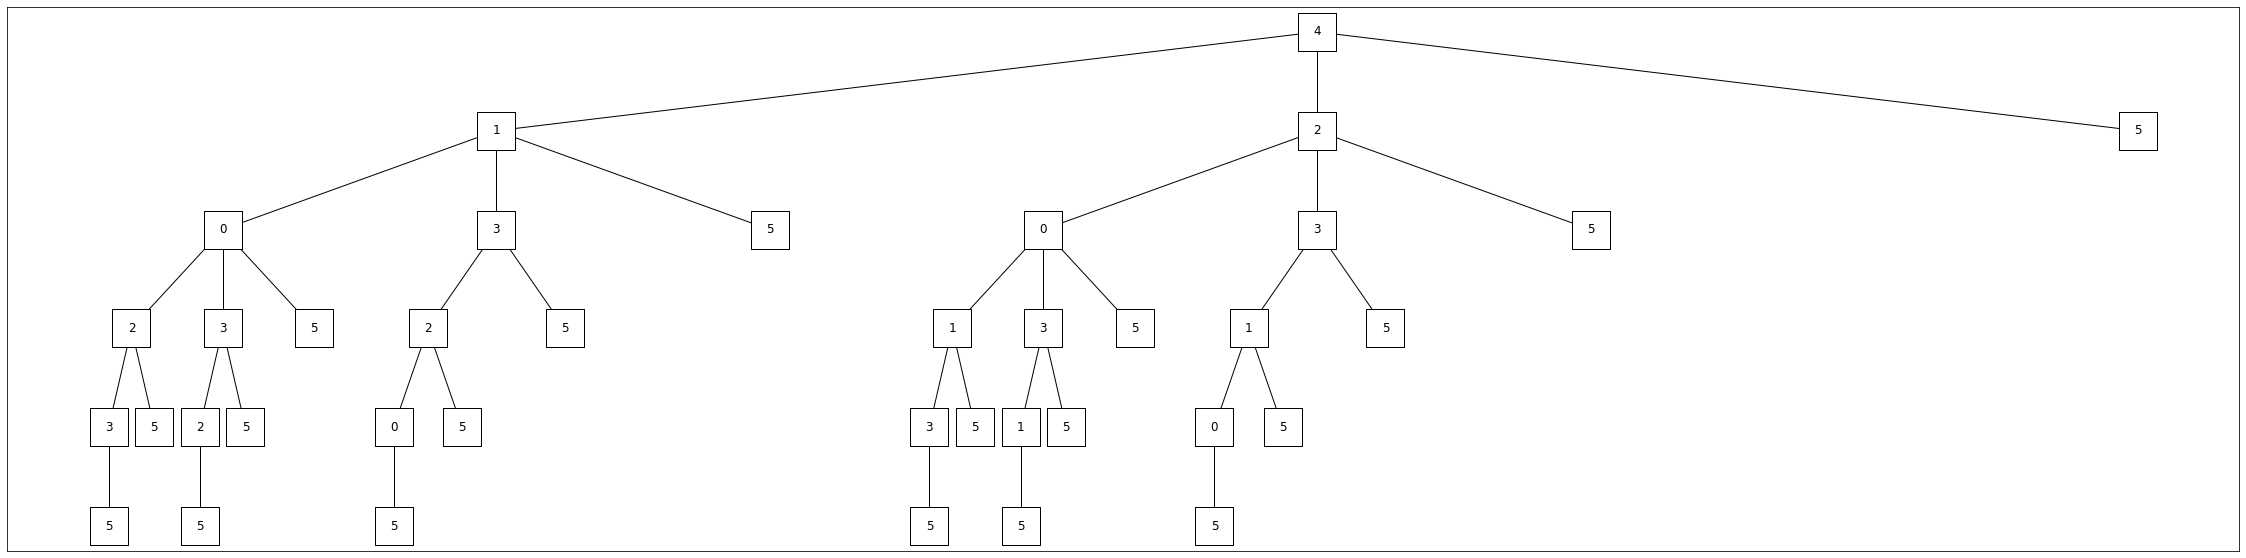

In [17]:
for target, row in enumerate(A):
    for source, element in enumerate(row):
        if source != target:
            tree = propagation_tree(g,target,source)
            plot_propagation_tree(tree)
            plt.savefig(f'propagation_from_{source}_to_{target}.png')

In [16]:
for i, row in enumerate(DSM):
    #print(row)
    for j, element in enumerate(row):
        if element == 1:
            print(f"There is an interface between {product_components[i]} and {product_components[j]}")


There is an interface between power supply and motor
There is an interface between power supply and heating unit
There is an interface between motor and power supply
There is an interface between motor and fan
There is an interface between motor and control system
There is an interface between motor and casing
There is an interface between heating unit and power supply
There is an interface between heating unit and fan
There is an interface between heating unit and control system
There is an interface between heating unit and casing
There is an interface between fan and power supply
There is an interface between fan and motor
There is an interface between fan and heating unit
There is an interface between fan and casing
There is an interface between control system and heating unit
There is an interface between control system and fan
There is an interface between control system and casing
There is an interface between casing and power supply
There is an interface between casing and moto

In [19]:
# Combined likelihood matrix (L)
L = []

In [20]:
# Combined impact matrix (I)
I = []

In [21]:
# Combined risk matrix (R)
R = []

### 1.4 Product Risk Matrix

In [22]:
def combined_risk(A,L,I,b,a):
    second = 1
    Anp = np.matrix(A)
    g = nx.from_numpy_matrix(Anp, create_using=nx.DiGraph)
    for path in nx.all_simple_paths(g, b, a):
        print(path)
        path_likelihood = 1
        path_risk = 1
        for node, source in enumerate(path):
            if source != a:
                destination = path[node+1]
                #print(f"From source {source} to destination {destination}:")
                likelihood = L[source][destination]
                impact = I[source][destination]
                risk = likelihood * impact
                path_likelihood = path_likelihood * likelihood
                path_risk = path_risk * (risk)
                #print(f"  Likelihood: {likelihood}")
                #print(f"  Impact    : {impact}")
                #print(f"  Risk      : {risk}")
        print(f"Path likelihood: {path_likelihood}")
        print(f"Path risk: {path_risk}")
        second = second * path_likelihood

    R = 1 - second
    return R

In [23]:
combined_risk(A,L,I,0,2)

[0, 1, 3, 2]


IndexError: list index out of range

0.0 0.0 0.0 0 0
1.0 0.0 0.27 0.3 0.9
2.0 0.0 0.27 0.3 0.9
0.0 1.0 0.0 0 0
1.0 1.0 0.0 0 0
2.0 1.0 0.0 0 0
0.0 2.0 0.81 0.9 0.9
1.0 2.0 0.0 0 0
2.0 2.0 0.0 0 0


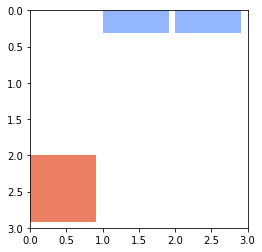

In [ ]:
from matplotlib.patches import Rectangle

#flat_list = [item for sublist in t for item in sublist]

#x  = [0.0,1.0,2.0,0.0,1.0,2.0,0.0,1.0,2.0]
#y  = [0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,2.0]
#z  = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#dx = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#dy = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]

x  = [0.0,1.0,2.0,0.0,1.0,2.0,0.0,1.0,2.0]
y  = [0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,2.0]
dx = [item for sublist in l for item in sublist]
dy = [item for sublist in i for item in sublist]
z = [item for sublist in r for item in sublist]

cmap = plt.cm.coolwarm
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

for x, y, c, h, w in zip(x, y, z, dx, dy):
    print(x, y, c, h, w)
    ax.add_artist(Rectangle(xy=(x, y),
                  color=cmap(c),
                  width=w, height=h))

plt.xlim([0, 3])
plt.ylim([0, 3])
plt.gca().invert_yaxis()
plt.show()

## 2. Case-by-Case Analysis

### 2.1 Identify Initiating Changes

### 2.2 Identify Predicted Changes

### 2.3 Case Risk Plot

## 3. Redesign

# Validation

## Random inputs

In [ ]:
n = 3

# DSM
A = random_DSM(n)
print("DSM:")
ppm(A)
#plot_graph(A)

# Direct likelihood matrix
l = random_prob_matrix(A)
print("Direct likelihood matrix l:")
ppm(l)
# Direct impact matrix
i = random_prob_matrix(A)
print("Direct impact matrix i:")
ppm(i)
# Direct risk matrix
r = (np.array(l)*np.array(i)).tolist()
print("Direct risk matrix r:")
ppm(r)

#plot_heatmap(A)
#plot_heatmap(l)
#plot_heatmap(i)
#plot_heatmap(r)

DSM:
0.000	0.000	0.000
1.000	0.000	0.000
1.000	1.000	0.000
Direct likelihood matrix l:
0.000	0.000	0.000
0.062	0.000	0.000
0.457	0.563	0.000
Direct impact matrix i:
0.000	0.000	0.000
0.520	0.000	0.000
0.964	0.650	0.000
Direct risk matrix r:
0.000	0.000	0.000
0.032	0.000	0.000
0.440	0.366	0.000
